In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import requests
import json
import time
import matplotlib.pyplot as plt
import sklearn
import sklearn.neighbors
import wordcloud 

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from scipy import stats
from PIL import Image
from bs4 import BeautifulSoup
from statsmodels.stats.proportion import proportions_ztest
from tqdm import tqdm
from time import sleep
from datetime import date, datetime
from google.colab import files

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
projects = pd.read_csv(r'/content/drive/MyDrive/Thesis/data/Data_all/Cleaned/projects.csv')
hacks = pd.read_csv(r'/content/drive/MyDrive/Thesis/data/Data_all/Cleaned/hacks.csv')
participants = pd.read_csv(r'/content/drive/MyDrive/Thesis/data/Data_all/Cleaned/participants.csv')
participants_locations = pd.read_csv(r'/content/drive/MyDrive/Thesis/data/Data_all/Cleaned/locations.csv')
hacks_dist = pd.read_csv(r'/content/drive/MyDrive/Thesis/data/Data_all/hacks_dists.csv')

## RQ1. Schedule

In [ ]:
hacks['hack_duration'] = hacks['hack_duration'] + 1
duration_diff = hacks[['hack_duration', 'Location']]

grouped_duration = duration_diff.groupby('Location').agg({'hack_duration':['mean','std']}) #add error bar and standart deviation, min, max
grouped_duration.columns = ['mean', 'std']
grouped_duration['mean'] = grouped_duration['mean'].round(2)
grouped_duration['std'] = grouped_duration['std'].round(2)
grouped_duration = grouped_duration.reset_index()


In [ ]:

mean_online_durat = np.mean(hacks.loc[(hacks['Location'] == 'Online'), 'hack_duration'])
mean_offline_durat = np.mean(hacks.loc[(hacks['Location'] == 'Offline'), 'hack_duration'])
SD_online_durat = np.std(hacks.loc[(hacks['Location'] == 'Online'), 'hack_duration'])
SD_offline_durat = np.std(hacks.loc[(hacks['Location'] == 'Offline'), 'hack_duration'])

print(f"Mean and SD hack duration for online hacks: {mean_online_durat}, {SD_online_durat}")
print(f"Mean and SD hack duration for offline hacks: {mean_offline_durat}, {SD_offline_durat}")

online_durat = hacks.loc[(hacks['Location'] == 'Online'), 'hack_duration'].values
offline_durat = hacks.loc[(hacks['Location'] == 'Offline'), 'hack_duration'].values

stat_t, p1 = stats.ttest_ind(online_durat, offline_durat)
print(f"T-statistic: {stat_t}, p-value {p1}")

stat_u, p2 = stats.mannwhitneyu(online_durat, offline_durat)
if p2 < 0.001:
  significance = '***'
elif p2 < 0.01:
  significance = '**'
elif p2 < 0.05:
  significance = '*'
elif p2 < 0.1:
  significance = '.'
else:
  significance = ''
print(f"U-statistic: {stat_u}, p-value {p2}, {significance}")


Mean and SD hack duration for online hacks: 4.256468797564688, 4.071149002097095
Mean and SD hack duration for offline hacks: 2.4517282479141835, 2.195616771750346
T-statistic: 20.671260533140178, p-value 1.7310827655532977e-91
U-statistic: 1660517.0, p-value 2.346328320700738e-118, ***


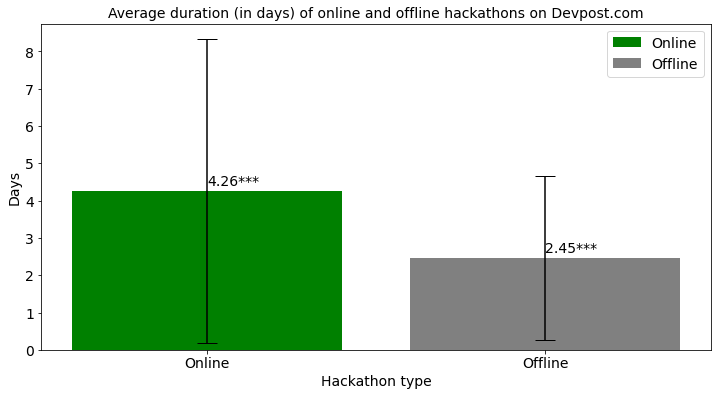

In [ ]:
colors = ['green', 'grey']
fig, ax = plt.subplots(figsize=(12, 6))
for c, loc in [['green','Online'],['grey','Offline']]:
  ax.bar(grouped_duration[grouped_duration.Location==loc].Location, grouped_duration[grouped_duration.Location==loc]['mean'], yerr=grouped_duration[grouped_duration.Location==loc]['std'], capsize=10,color = c, label='mean duration')
  ax.set_title('Average duration (in days) of online and offline hackathons on Devpost.com', fontsize=14)
  ax.set_xlabel('Hackathon type', fontsize=14)
  ax.set_ylabel('Days', fontsize=14)
  ax.legend(['Online', 'Offline'], fontsize=14)
  ax.xaxis.set_ticks(grouped_duration.Location)
  ax.tick_params(axis='both', which='major', labelsize=14)

for i, row in grouped_duration.iterrows():
  ax.annotate(str(row['mean'])+significance, xy=(row['Location'], row['mean'] + 0.15), fontsize=14)
plt.show()
#usually the end date of hackathon in Devpost is the date when the submission ends! Therefore we made an additional analysis of schedules
#also if the start and end date are the same the duration would be 1 day, not 0 days (so, we are adding 1 day to all durations)!!!!!!!!!!!

## Now let's investigate schedules of hackathons

In [ ]:
sched = hacks[['schedule', 'start_date_format', 'end_date_format', 'Location']]

In [ ]:
sched['schedule'] = sched['schedule'].str.replace('Public Voting', 'Public_Voting')
sched['schedule'] = sched['schedule'].str.replace('Winners Announced', 'Winners_Announced')
sched['start_date_format'] = pd.to_datetime(sched['start_date_format'])
sched['end_date_format'] = pd.to_datetime(sched['end_date_format'])
sched['year'] = sched['end_date_format'].dt.year

In [ ]:
df_extended_sched = sched['schedule'].str.split(', ', expand=True)

In [ ]:
t = ' '
df_extended_sched['First stage'] = df_extended_sched[0].str.split(t).str[0].str.strip()
df_extended_sched['Second stage'] = df_extended_sched[1].str.split(t).str[0].str.strip()
df_extended_sched['Third stage'] = df_extended_sched[2].str.split(t).str[0].str.strip()
df_extended_sched['Forth(additional) stage'] = df_extended_sched[3].str.split(t).str[0].str.strip()
df_extended_sched['First stage start time'] = df_extended_sched[0].str.split(t).str[1].str.strip()+' '+df_extended_sched[0].str.split(t).str[2].str.strip()
df_extended_sched['First stage end time'] = df_extended_sched[0].str.split(t).str[6].str.strip()+' '+df_extended_sched[0].str.split(t).str[7].str.strip()
df_extended_sched['Second stage start time'] = df_extended_sched[1].str.split(t).str[1].str.strip()+' '+df_extended_sched[1].str.split(t).str[2].str.strip()
df_extended_sched['Second stage end time'] = df_extended_sched[1].str.split(t).str[6].str.strip()+' '+df_extended_sched[1].str.split(t).str[7].str.strip()
# df_extended_sched['Third stage start time'] = df_extended_sched[2].str.split(t).str[1].str.strip()+' '+df_extended_sched[2].str.split(t).str[2].str.strip()+' '+df_extended_sched[2].str.split(t).str[4].str.strip()
# df_extended_sched['Third stage end time'] = df_extended_sched[2].str.split(t).str[6].str.strip()+' '+df_extended_sched[2].str.split(t).str[7].str.strip()+' '+df_extended_sched[2].str.split(t).str[9].str.strip()

forth_stage_start_time = []
forth_stage_end_time = []

for s in df_extended_sched[3]:
  if s:
    splited_str = [w for w in s.split(t) if w != '']
    forth_stage_start_time.append(splited_str[1].strip()+' '+splited_str[2].strip())
    if len(splited_str) < 7:
      forth_stage_end_time.append('')
    else:
      forth_stage_end_time.append(s.split(t)[6].strip()+' '+s.split(t)[7].strip())

  else:
    forth_stage_start_time.append('')
    forth_stage_end_time.append('')

third_stage_start_time = []
third_stage_end_time = []

for s in df_extended_sched[2]:
  if s:
    splited_str = [w for w in s.split(t) if w != '']
    if len(splited_str)==1:
      third_stage_start_time.append('')
      third_stage_end_time.append('')
    else:
      third_stage_start_time.append(splited_str[1].strip()+' '+splited_str[2].strip())
      if len(splited_str) < 7:
        third_stage_end_time.append('')
      else:
        third_stage_end_time.append(s.split(t)[6].strip()+' '+s.split(t)[7].strip())
  else:
    third_stage_start_time.append('')
    third_stage_end_time.append('')

In [ ]:
df_extended_sched['Third stage start time'] = third_stage_start_time
df_extended_sched['Third stage end time'] = third_stage_end_time
df_extended_sched['Forth stage start time'] = forth_stage_start_time
df_extended_sched['Forth stage end time'] = forth_stage_end_time

In [ ]:
sched = sched.join(df_extended_sched[['First stage', 'Second stage', 'Third stage', 'Forth(additional) stage', 'First stage start time','First stage end time','Second stage start time','Second stage end time','Third stage start time','Third stage end time', 'Forth stage start time', 'Forth stage end time']])

In [ ]:
filt = sched['First stage start time']!= ''
sched.loc[filt,'First stage start time'] = pd.to_datetime(sched.loc[filt,'First stage start time'].str.cat(sched.loc[filt,'year'].astype(str), sep =" "))

filt_2 = sched['First stage end time']!= ''
sched.loc[filt_2,'First stage end time'] = pd.to_datetime(sched.loc[filt_2,'First stage end time'].str.cat(sched.loc[filt_2,'year'].astype(str), sep =" "))

filt_3 = sched['Second stage start time'].notna()
sched.loc[filt_3,'Second stage start time'] = pd.to_datetime(sched.loc[filt_3,'Second stage start time'].str.cat(sched.loc[filt_3,'year'].astype(str), sep =" "))

filt_4 = sched['Second stage end time'].notna()
sched.loc[filt_4,'Second stage end time'] = pd.to_datetime(sched.loc[filt_4,'Second stage end time'].str.cat(sched.loc[filt_4,'year'].astype(str), sep =" "))

filt_5 = sched['Third stage start time']!= ''
sched.loc[filt_5,'Third stage start time'] = pd.to_datetime(sched.loc[filt_5,'Third stage start time'].str.cat(sched.loc[filt_5,'year'].astype(str), sep =" "))

filt_6 = sched['Third stage end time']!= ''
sched.loc[filt_6,'Third stage end time'] = pd.to_datetime(sched.loc[filt_6,'Third stage end time'].str.cat(sched.loc[filt_6,'year'].astype(str), sep =" "))

filt_7 = sched['Forth stage start time']!= ''
sched.loc[filt_7, 'Forth stage start time'] = pd.to_datetime(sched.loc[filt_7,'Forth stage start time'].str.cat(sched.loc[filt_7,'year'].astype(str), sep =" "))

filt_8 = sched['Forth stage end time']!= ''
sched.loc[filt_8, 'Forth stage end time'] = pd.to_datetime(sched.loc[filt_8,'Forth stage start time'].str.cat(sched.loc[filt_8,'year'].astype(str), sep =" "))

In [ ]:
hacks_real_end_date = sched
filter = hacks_real_end_date['Third stage'] == 'Judging'
filter_2 = hacks_real_end_date['Third stage'] == 'Winners_Announced'
hacks_real_end_date.loc[filter_2, 'Real end date']= pd.to_datetime(hacks_real_end_date.loc[filter_2, 'Third stage start time'])
hacks_real_end_date.loc[filter, 'Real end date'] = hacks_real_end_date.loc[filter, 'Forth stage start time']
hacks_real_end_date['Real end date'] = pd.to_datetime(hacks_real_end_date['Real end date'])

# df['Cat1'].fillna(df['Cat2'])

In [ ]:
hacks = hacks.join(hacks_real_end_date[['Real end date']])
hacks['start_date_format'] = pd.to_datetime(hacks['start_date_format'])
hacks['hack_duration_total'] = (hacks['Real end date'] - hacks['start_date_format']).dt.days + 1

In [ ]:
filt_year = hacks['hack_duration_total']<0
hacks.loc[filt_year, 'Real end date'] = (hacks.loc[filt_year, 'Real end date'].dt.year+1).astype(str)+'-'+(hacks.loc[filt_year, 'Real end date'].dt.month).astype(str)+'-'+(hacks.loc[filt_year, 'Real end date'].dt.day).astype(str)
hacks.loc[filt_year, 'Real end date'] = pd.to_datetime(hacks.loc[filt_year, 'Real end date'])

In [ ]:
hacks['Real end date'] = pd.to_datetime(hacks['Real end date'])
hacks.loc[filt_year, 'hack_duration_total'] = (hacks.loc[filt_year,'Real end date'] - hacks.loc[filt_year,'start_date_format']).dt.days + 1
hacks = hacks[hacks['hack_duration_total']<100]

In [ ]:
#from datetime import timedelta

real_duration_diff = hacks[['hack_duration_total', 'Location']]

grouped_duration = real_duration_diff.groupby('Location').agg({'hack_duration_total':['mean','std']}) #add error bar and standart deviation, min, max
grouped_duration = real_duration_diff.groupby('Location').agg({'hack_duration_total':['mean','std']}) #add error bar and standart deviation, min, max
grouped_duration.columns = ['mean', 'std']
grouped_duration['mean'] = grouped_duration['mean'].round(2)
grouped_duration['std'] = grouped_duration['std'].round(2)
grouped_duration = grouped_duration.reset_index()

mean_online_durat = np.mean(hacks.loc[(hacks['Location'] == 'Online'), 'hack_duration_total'])
mean_offline_durat = np.mean(hacks.loc[(hacks['Location'] == 'Offline'), 'hack_duration_total'])
SD_online_durat = np.std(hacks.loc[(hacks['Location'] == 'Online'), 'hack_duration_total'])
SD_offline_durat = np.std(hacks.loc[(hacks['Location'] == 'Offline'), 'hack_duration_total'])

print(f"Mean hack duration for online hacks: {mean_online_durat},{SD_online_durat}")
print(f"Mean hack duration for offline hacks: {mean_offline_durat},{SD_offline_durat}")

online_durat = hacks.loc[(hacks['Location'] == 'Online'), 'hack_duration_total'].values
offline_durat = hacks.loc[(hacks['Location'] == 'Offline'), 'hack_duration_total'].values

from scipy import stats

stat_t, p1 = stats.ttest_ind(online_durat, offline_durat)
print(f"T-statistic: {stat_t}, p-value {p1}")

stat_u, p2 = stats.mannwhitneyu(online_durat, offline_durat)
if p2 < 0.001:
  significance = '***'
elif p2 < 0.01:
  significance = '**'
elif p2 < 0.05:
  significance = '*'
elif p2 < 0.1:
  significance = '.'
else:
  significance = ''
print(f"U-statistic: {stat_u}, p-value {p2}, {significance}")

In [ ]:
colors = ['green', 'grey']
fig, ax = plt.subplots(figsize=(12, 6))
for c, loc in [['green','Online'],['grey','Offline']]:
  ax.bar(grouped_duration[grouped_duration.Location==loc].Location, grouped_duration[grouped_duration.Location==loc]['mean'], yerr=grouped_duration[grouped_duration.Location==loc]['std'], capsize=10,color = c, label='mean duration')
  ax.set_title('Average total duration (in days) of online and offline hackathons on Devpost.com', fontsize=14)
  ax.set_xlabel('Hackathon type', fontsize=14)
  ax.set_ylabel('Days', fontsize=14)
  ax.legend(['Online', 'Offline'], fontsize=14)
  ax.xaxis.set_ticks(grouped_duration.Location)
  ax.tick_params(axis='both', which='major', labelsize=14)

for i, row in grouped_duration.iterrows():
  ax.annotate(str(row['mean'])+significance, xy=(row['Location'], row['mean'] + 0.15), fontsize=14)
plt.show()
#usually the end date of hackathon in Devpost is the date when the submission ends! Therefore we made an additional analysis of schedules

In [ ]:
 sched.columns = ['schedule', 'start_date_format', 'end_date_format', 'status', 'year',
       '1_stage', '2_stage', '3_stage', '4_stage',
       '1_stage_start_time', '1_stage_end_time',
       '2_stage_start_time', '2_stage_end_time',
       '3_stage_start_time', '3_stage_end_time',
       '4_stage_start_time', '4_stage_end_time',
       'real_end_date']

# replace field that's entirely space (or empty) with NaN
sched = sched.replace(r'^\s*$', np.nan, regex=True)

for i in range(1, 5):
  sched[f"{i}_stage_start_time"] = pd.to_datetime(sched[f"{i}_stage_start_time"])
  sched[f"{i}_stage_end_time"] = pd.to_datetime(sched[f"{i}_stage_end_time"])

In [ ]:
sched[sched.status == 'Online'][['1_stage', '2_stage', '3_stage', '4_stage', 'status']].groupby(by=['1_stage', '2_stage', '3_stage', '4_stage'], dropna=False).count()

In [ ]:
sched[sched.status == 'Offline'][['1_stage', '2_stage', '3_stage', '4_stage', 'status']].groupby(by=['1_stage', '2_stage', '3_stage', '4_stage'], dropna=False).count()

In [ ]:
test = (sched['2_stage_end_time'] - sched['2_stage_start_time']).dt.days
# test = test.fillna(test.median())
# test.mean()
sched['2_stage_end_time'].iloc[0] - sched['2_stage_end_time'].iloc[-1]

In [ ]:
def get_stages_duration_info(df):
  case_filter = df['3_stage'] == 'Judging'
  result_dfs = []

  for i, case_df in enumerate([df[~case_filter], df[case_filter]]):
    result_df = pd.DataFrame(columns=['status', '1_stage_avg_duration', '1_stage_SD', '2_stage_avg_duration','2_stage_SD', '1-2_stages_time_gap','1-2_stage_SD', '2-3_stages_time_gap','2-3_stage_SD'])
    stages_nums = list(range(1, 3))

    if i == 1:
      result_df['3_stage_avg_duration'],result_df['3_stage_SD'],result_df['3-4_stages_time_gap'], result_df['3-4_stage_SD'] = None, None, None, None
      stages_nums.append(3)

    for j, s in enumerate(['Online', 'Offline']):
      case_status_df = case_df[case_df.status == s]
      
      result_df = result_df.append(pd.Series(), ignore_index=True)
      result_df.loc[j, "status"] = s
      for stage_n in stages_nums:
        result_df.loc[j, [f"{stage_n}_stage_avg_duration"]] = ((case_status_df[f"{stage_n}_stage_end_time"] - case_status_df[f"{stage_n}_stage_start_time"]).dt.days + 1).mean()
        result_df.loc[j, [f"{stage_n}_stage_SD"]] = ((case_status_df[f"{stage_n}_stage_end_time"] - case_status_df[f"{stage_n}_stage_start_time"]).dt.days + 1).std()
        result_df.loc[j, [f"{stage_n}-{stage_n + 1}_stages_time_gap"]] = (case_status_df[f"{stage_n + 1}_stage_start_time"] - case_status_df[f"{stage_n}_stage_end_time"]).dt.days.mean()
        result_df.loc[j, [f"{stage_n}-{stage_n + 1}_stage_SD"]] = (case_status_df[f"{stage_n + 1}_stage_start_time"] - case_status_df[f"{stage_n}_stage_end_time"]).dt.days.std()
        
      
    result_dfs.append(result_df)
  return result_dfs

In [ ]:
res = get_stages_duration_info(sched)

### Case 1: 

1. Submission -> 2. Judging -> 3. Winners_Announced

In [ ]:
res[0]

### Case 2:

1. Submission -> 2. Public_Voting	-> 3. Judging -> 4. Winners_Announced

In [ ]:
res[1]

## RQ4. Tools

In [5]:
test = projects[['build_with', 'submission_gal_url', 'Location']]
N_top = 20

In [6]:
test_before = test[test['Location'] == 'Online']
build_with_flatten_before = test_before['build_with'].str.split(', ', expand=True).stack()
test_before = pd.DataFrame({'build_with': build_with_flatten_before, 'count': range(len(build_with_flatten_before))})
test_before.reset_index(drop=True, inplace=True)
grouped_skills_before = test_before.groupby('build_with').count().sort_values('count', ascending=False)
# grouped_skills_before_sum = grouped_skills_before.head(N_top)['count'].sum() # took only N_top!!!
# grouped_skills_before_pct = grouped_skills_before.head(N_top)['count'] / grouped_skills_before_sum * 100
grouped_skills_before_sum = grouped_skills_before['count'].sum()
grouped_skills_before_pct = grouped_skills_before['count'] / grouped_skills_before_sum * 100
grouped_skills_before['pct'] = grouped_skills_before_pct.round(1)
grouped_skills_before = grouped_skills_before.reset_index()
#see how exactly main cloud platforms usage has changed!

In [7]:
test_after = test[test['Location'] == 'Offline']
build_with_flatten_after = test_after['build_with'].str.split(', ', expand=True).stack()
test_after = pd.DataFrame({'build_with': build_with_flatten_after, 'count': range(len(build_with_flatten_after))})
test_after.reset_index(drop=True, inplace=True)
grouped_skills_after = test_after.groupby('build_with').count().sort_values('count', ascending=False)
# grouped_skills_after_sum = grouped_skills_after.head(N_top)['count'].sum() # took only N_top!!!
# grouped_skills_after_pct = grouped_skills_after.head(N_top)['count'] / grouped_skills_after_sum * 100
grouped_skills_after_sum = grouped_skills_after['count'].sum()
grouped_skills_after_sum = len(test_before)
grouped_skills_after_pct = grouped_skills_after['count'] / grouped_skills_after_sum * 100
grouped_skills_after['pct'] = grouped_skills_after_pct.round(1)
grouped_skills_after = grouped_skills_after.reset_index()

In [8]:
before_skills = grouped_skills_before.loc[:N_top, 'build_with'].tolist()
after_skills = grouped_skills_after.loc[:N_top, 'build_with'].tolist()
skills = list(set(before_skills + after_skills))
skills_pval = {}

for s in skills:
  online_skill_count = grouped_skills_before.loc[grouped_skills_before['build_with'] == s, 'count'].iloc[0]
  offline_skill_count = grouped_skills_after.loc[grouped_skills_after['build_with'] == s, 'count'].iloc[0]
  _, pval = proportions_ztest([online_skill_count, offline_skill_count], [grouped_skills_before_sum, grouped_skills_after_sum])

  significance = ''
  if pval < 0.001:
    significance = '***'
  elif pval < 0.01:
    significance = '**'
  elif pval < 0.05:
    significance = '*'
  elif pval < 0.1:
    significance = '.'

  skills_pval[s] = (round(pval, 4), significance)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [9]:
grouped_skills_before = grouped_skills_before.iloc[:N_top, :]
grouped_skills_after = grouped_skills_after.iloc[:N_top, :]

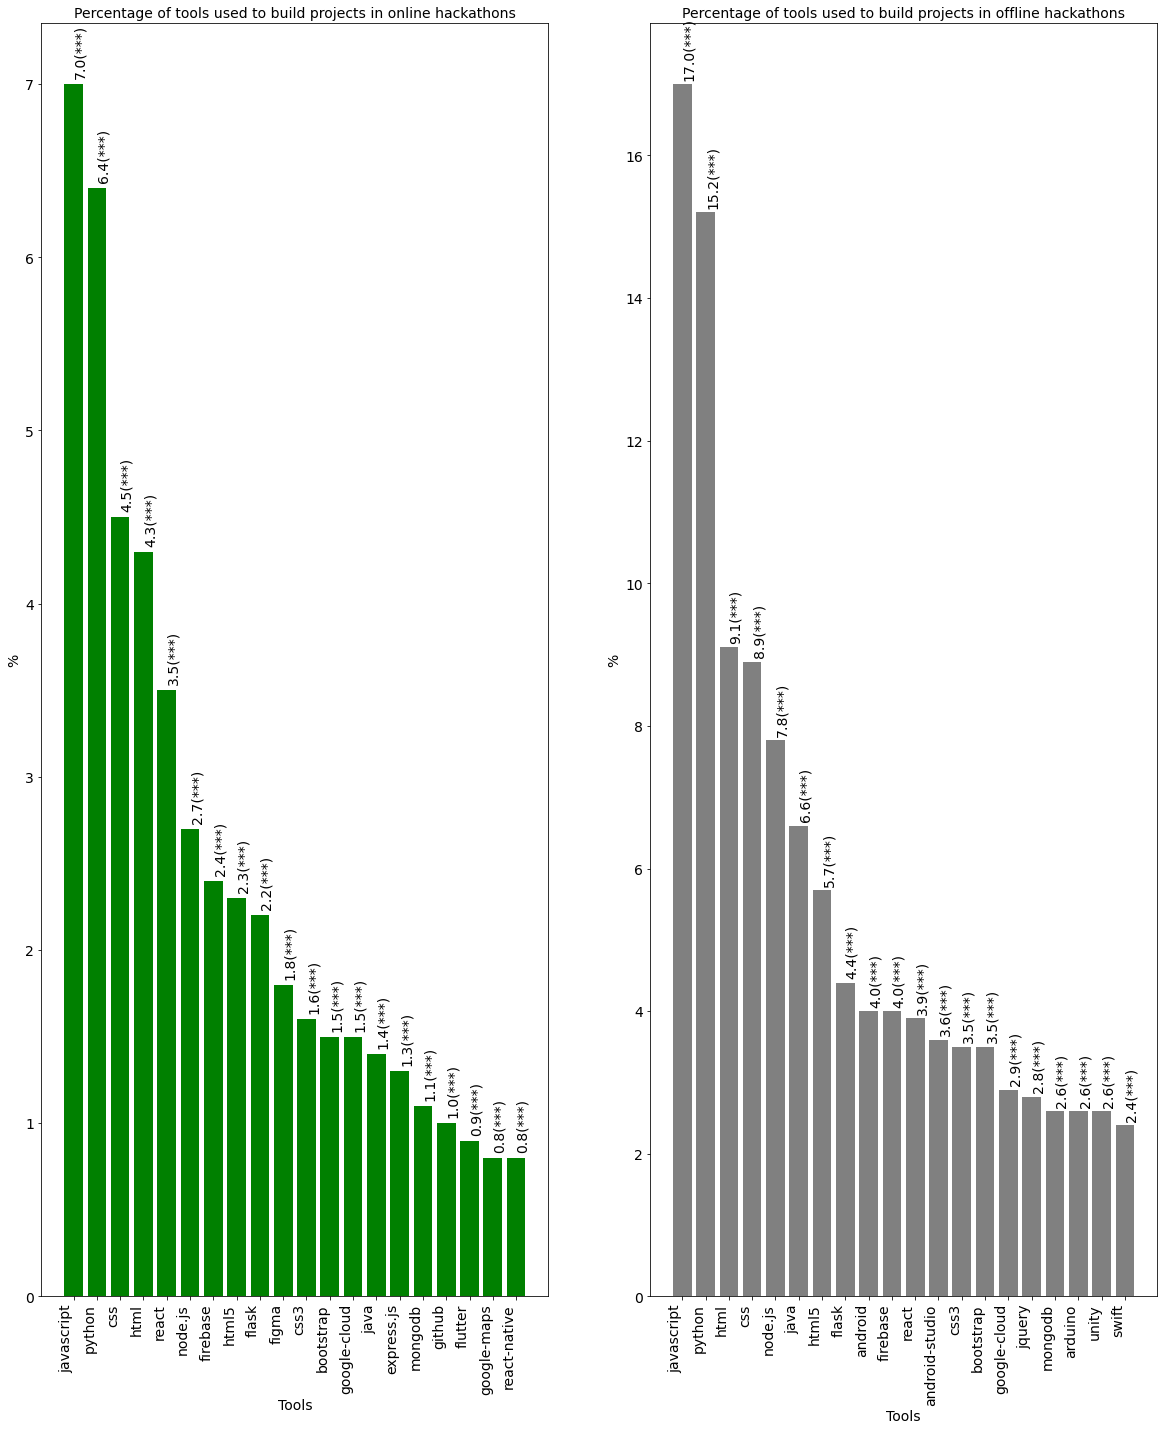

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(20, 26))

axs[0].set_title("Percentage of tools used to build projects in online hackathons", fontsize=14)
axs[0].set_ylabel("%", fontsize=14)
axs[0].set_xlabel("Tools", fontsize=14)
axs[0].bar(grouped_skills_before['build_with'], grouped_skills_before['pct'], color = 'green')

for i, row in grouped_skills_before.iterrows():
  axs[0].annotate(str(row['pct'])+f"({skills_pval[row['build_with']][1]})", xy=(row['build_with'], row['pct']+ 0.05), rotation=90, fontsize=14)
axs[0].tick_params(axis='both', which='major', labelsize=14)

axs[1].set_title("Percentage of tools used to build projects in offline hackathons", fontsize=14)
axs[1].set_ylabel("%", fontsize=14)
axs[1].set_xlabel("Tools", fontsize=14)
axs[1].bar(grouped_skills_after['build_with'], grouped_skills_after['pct'], color = 'grey')

for i, row in grouped_skills_after.iterrows():
  axs[1].annotate(str(row['pct'])+f"({skills_pval[row['build_with']][1]})", xy=(row['build_with'], row['pct'] + 0.1), rotation=90, fontsize=14)
axs[1].tick_params(axis='both', which='major', labelsize=14)

fig.autofmt_xdate(rotation=90)

In [12]:
online_crit = {row['build_with']:row['count'] for _, row in grouped_skills_before[['build_with', 'count']].iterrows()}
offline_crit = {row['build_with']:row['count'] for _, row in grouped_skills_after[['build_with', 'count']].iterrows()}

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


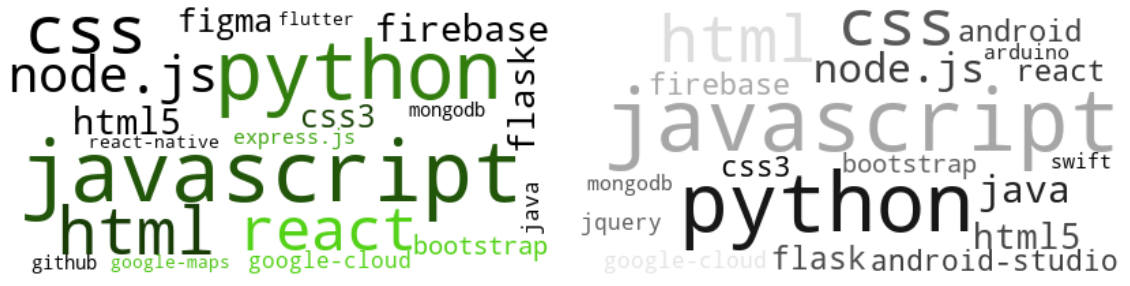

In [15]:
stopwords = set(STOPWORDS)
mask = np.array(Image.open(r'/content/drive/MyDrive/Thesis/cloud.png').convert("RGB"))
mask_2 = np.array(Image.open(r'/content/drive/MyDrive/Thesis/university-building.png').convert("RGB"))
image_colors = ImageColorGenerator(mask)
image_colors_2 = ImageColorGenerator(mask_2)
fig, axs = plt.subplots(1, 2, figsize=(20, 20))

wc1 = WordCloud(stopwords=stopwords,background_color='white', max_words=1000,collocations=False, colormap='rainbow').generate_from_frequencies(online_crit)

wc2 = WordCloud(stopwords=stopwords,background_color='white', max_words=1000,collocations=False, colormap='rainbow').generate_from_frequencies(offline_crit)


axs[0].imshow(wc1.recolor(color_func=image_colors), interpolation="bilinear")
axs[0].axis('off')
axs[1].imshow(wc2.recolor(color_func=image_colors_2), interpolation="bilinear")
axs[1].axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0.05)

In [16]:
test_before = test[test['Location'] == 'Online']
build_with_flatten_before = test_before['build_with'].str.split(', ', expand=True).stack()
test_before = pd.DataFrame({'build_with': build_with_flatten_before, 'count': range(len(build_with_flatten_before))})
test_before.reset_index(drop=True, inplace=True)
grouped_skills_before = test_before.groupby('build_with').count().sort_values('count', ascending=False)
grouped_skills_before_sum = grouped_skills_before['count'].sum()
grouped_skills_before_pct = grouped_skills_before['count'] / grouped_skills_before_sum * 100
grouped_skills_before['pct_online'] = grouped_skills_before_pct.round(2)
grouped_skills_before = grouped_skills_before.reset_index()

In [17]:
test_after = test[test['Location'] == 'Offline']
build_with_flatten_after = test_after['build_with'].str.split(', ', expand=True).stack()
test_after = pd.DataFrame({'build_with': build_with_flatten_after, 'count': range(len(build_with_flatten_after))})
test_after.reset_index(drop=True, inplace=True)
grouped_skills_after = test_after.groupby('build_with').count().sort_values('count', ascending=False)
grouped_skills_after_sum = grouped_skills_after['count'].sum()
grouped_skills_after_pct = grouped_skills_after['count'] / grouped_skills_after_sum * 100
grouped_skills_after['pct_offline'] = grouped_skills_after_pct.round(2)
grouped_skills_after = grouped_skills_after.reset_index()

In [29]:
all_skills = grouped_skills_before.merge(grouped_skills_after, on='build_with')
d = all_skills.sort_values(by='pct_offline', ascending=False)
#github, google cloud, heroku, discord usage increased in online hackathons
#on the other hand azure, twilio, amazon-web-services are at least somehow decreased when compare online vs offline
d.to_csv('all_skills')

In [ ]:
#how many projects had github in online and offline hacks

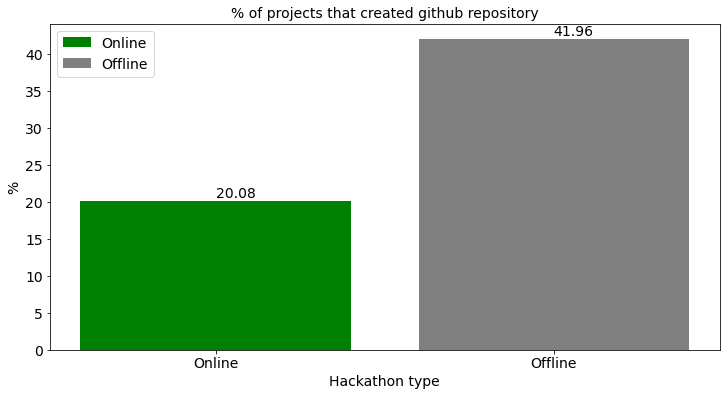

In [ ]:
github_diff = projects[['github_links', 'Location']] 

grouped_github = github_diff.groupby('Location').count() #add error bar and standart deviation, min, max
grouped_github_sum = len(github_diff)
grouped_github['github_links'] = grouped_github['github_links']/grouped_github_sum*100
grouped_github['github_links'] = round(grouped_github['github_links'],2)

grouped_github = grouped_github.reset_index()
colors = ['green', 'grey']
fig, ax = plt.subplots(figsize=(12, 6))
for c, loc in [['green','Online'],['grey','Offline']]:
  ax.bar(grouped_github[grouped_github.Location==loc].Location,grouped_github[grouped_github.Location==loc].github_links, color = c, label='%')
  ax.set_title('% of projects that created github repository', fontsize=14)
  ax.set_xlabel('Hackathon type', fontsize=14)
  ax.set_ylabel('%', fontsize=14)
  ax.legend(['Online', 'Offline'], fontsize=14)
  ax.xaxis.set_ticks(grouped_github.Location)
  ax.tick_params(axis='both', which='major', labelsize=14)

for i, row in grouped_github.iterrows():
  ax.annotate(str(row['github_links']), xy=(row['Location'], row['github_links'] + 0.5), fontsize=14)
plt.show()


In [ ]:
repo = projects[projects['repo'].notna()]
repo = repo[repo['repo']!='Nan']
repo_flatten = repo['repo'].str.split(', ', expand=True).stack()
repo_flatten.unique().tolist()

#from this list we cannot say much about other usage of online or cloud tools while creating the project solution

## RQ2 Criteria

Here we will also check for judging criterias distribution among online and offline hackathons

In [76]:
test = projects[['Criteria', 'submission_gal_url', 'Location']]
test['Criteria'] = test['Criteria'].str.lower()
N_top = 20

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [86]:
test_before = test[test['Location'] == 'Online']
build_with_flatten_before = test_before['Criteria'].str.split(', ', expand=True).stack()
test_before = pd.DataFrame({'Criteria': build_with_flatten_before, 'count': range(len(build_with_flatten_before))})
test_before.reset_index(drop=True, inplace=True)
grouped_skills_before = test_before.groupby('Criteria').count().sort_values('count', ascending=False)
# grouped_skills_before_sum = grouped_skills_before.head(N_top)['count'].sum() # took only N_top!!!
# grouped_skills_before_pct = grouped_skills_before.head(N_top)['count'] / grouped_skills_before_sum * 100
grouped_skills_before_sum = grouped_skills_before['count'].sum()
grouped_skills_before_pct = grouped_skills_before['count'] / grouped_skills_before_sum * 100
grouped_skills_before['pct'] = grouped_skills_before_pct.round(1)
grouped_skills_before = grouped_skills_before.reset_index()
#see how exactly main cloud platforms usage has changed!

In [87]:
test_after = test[test['Location'] == 'Offline']
build_with_flatten_after = test_after['Criteria'].str.split(', ', expand=True).stack()
test_after = pd.DataFrame({'Criteria': build_with_flatten_after, 'count': range(len(build_with_flatten_after))})
test_after.reset_index(drop=True, inplace=True)
grouped_skills_after = test_after.groupby('Criteria').count().sort_values('count', ascending=False)
# grouped_skills_after_sum = grouped_skills_after.head(N_top)['count'].sum() # took only N_top!!!
# grouped_skills_after_pct = grouped_skills_after.head(N_top)['count'] / grouped_skills_after_sum * 100
grouped_skills_after_sum = grouped_skills_after['count'].sum()
grouped_skills_after_pct = grouped_skills_after['count'] / grouped_skills_after_sum * 100
grouped_skills_after['pct'] = grouped_skills_after_pct.round(1)
grouped_skills_after = grouped_skills_after.reset_index()

In [95]:
all_skills = grouped_skills_before.merge(grouped_skills_after, on='Criteria')
d = all_skills.sort_values(by='pct_y', ascending=False)
#github, google cloud, heroku, discord usage increased in online hackathons
#on the other hand azure, twilio, amazon-web-services are at least somehow decreased when compare online vs offline
d.to_csv('all_skills')

In [80]:
before_skills = grouped_skills_before.loc[:N_top, 'Criteria'].tolist()
after_skills = grouped_skills_after.loc[:N_top, 'Criteria'].tolist()
# before_skills = grouped_skills_before['Criteria'].tolist()
# after_skills = grouped_skills_after['Criteria'].tolist()
skills = list(set(before_skills).intersection(set(after_skills)))
skills_pval = {}

for s in skills:
  online_skill_count = grouped_skills_before.loc[grouped_skills_before['Criteria'] == s, 'count'].iloc[0]
  offline_skill_count = grouped_skills_after.loc[grouped_skills_after['Criteria'] == s, 'count'].iloc[0]
  _, pval = proportions_ztest([online_skill_count, offline_skill_count], [grouped_skills_before_sum, grouped_skills_after_sum])

  significance = ''
  if pval < 0.001:
    significance = '***'
  elif pval < 0.01:
    significance = '**'
  elif pval < 0.05:
    significance = '*'
  elif pval < 0.1:
    significance = '.'

  skills_pval[s] = (round(pval, 4), significance)

In [81]:
grouped_skills_before = grouped_skills_before.iloc[:N_top, :]
grouped_skills_after = grouped_skills_after.iloc[:N_top, :]

In [96]:
fig, axs = plt.subplots(1, 2, figsize=(35, 25))

axs[0].set_title("Percentage of online hackathons' judging criteria", fontsize=16)
axs[0].set_xlabel("%", fontsize=16)
axs[0].set_ylabel("Criteria", fontsize=16)
axs[0].barh(grouped_skills_before['Criteria'].iloc[::-1], grouped_skills_before['pct'].iloc[::-1], color = 'green')

for i, row in grouped_skills_before.iterrows():
  significance = ''
  if row['Criteria'] in skills_pval:
    significance = f"{skills_pval[row['Criteria']][1]}"
  axs[0].annotate(str(row['pct'])+significance, xy=(row['pct']+ 0.05, row['Criteria']), fontsize=16)
axs[0].tick_params(axis='both', which='major', labelsize=16)

axs[1].set_title("Percentage of offline hackathons judging criterias", fontsize=16)
axs[1].set_xlabel("%", fontsize=16)
axs[1].set_ylabel("Criteria", fontsize=16)
axs[1].barh(grouped_skills_after['Criteria'].iloc[::-1], grouped_skills_after['pct'].iloc[::-1], color = 'grey')

for i, row in grouped_skills_after.iterrows():
  significance = ''
  if row['Criteria'] in skills_pval:
    significance = f"{skills_pval[row['Criteria']][1]}"
  axs[1].annotate(str(row['pct'])+significance, xy=(row['pct']+ 0.05, row['Criteria']), fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=16)

fig.autofmt_xdate(rotation=90)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21407 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21019 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24615 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65292 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24819 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27861 missing from current font.
  font.set_

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f25c64d75f0> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f25c64df0e0> (for post_execute):


KeyboardInterrupt: ignored

In [89]:
online_crit = {row['Criteria']:row['count'] for _, row in grouped_skills_before[['Criteria', 'count']].iterrows()}
offline_crit = {row['Criteria']:row['count'] for _, row in grouped_skills_after[['Criteria', 'count']].iterrows()}

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


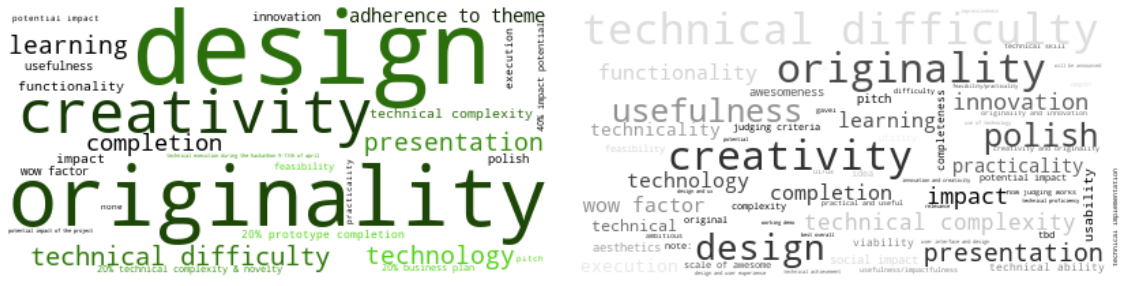

In [94]:
mask = np.array(Image.open(r'/content/drive/MyDrive/Thesis/cloud.png').convert("RGB"))
mask_2 = np.array(Image.open(r'/content/drive/MyDrive/Thesis/university-building.png').convert("RGB"))
image_colors = ImageColorGenerator(mask)
image_colors_2 = ImageColorGenerator(mask_2)
fig, axs = plt.subplots(1, 2, figsize=(20, 20))

wc1 = WordCloud(stopwords=stopwords,background_color='white', max_words=1000,collocations=False, colormap='rainbow').generate_from_frequencies(online_crit)

wc2 = WordCloud(stopwords=stopwords,background_color='white', max_words=1000,collocations=False, colormap='rainbow').generate_from_frequencies(offline_crit)


axs[0].imshow(wc1.recolor(color_func=image_colors), interpolation="bilinear")
axs[0].axis('off')
axs[1].imshow(wc2.recolor(color_func=image_colors_2), interpolation="bilinear")
axs[1].axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0.05)

RQ4. Participants' skilld

It's also important to check here what skills do participants have in online VS offline hackathons to be able to create projects for such a diverse themes and criterias

In [50]:
data = projects
data = data[['Location', 'participants']]
data = (data.set_index('Location')
   .apply(lambda x: x.str.split(',').explode())
   .reset_index()) 
data = data.merge(participants, left_on = 'participants',right_on = '0', how='left')
data = data[['Location', 'skills']]

In [51]:
N_top = 50

In [52]:
test_before = data[data['Location'] == 'Online']
build_with_flatten_before = test_before['skills'].str.split(', ', expand=True).stack()
test_before = pd.DataFrame({'skills': build_with_flatten_before, 'count': range(len(build_with_flatten_before))})
test_before.reset_index(drop=True, inplace=True)
grouped_skills_before = test_before.groupby('skills').count().sort_values('count', ascending=False)
# grouped_skills_before_sum = grouped_skills_before.head(N_top)['count'].sum() # took only N_top!!!
# grouped_skills_before_pct = grouped_skills_before.head(N_top)['count'] / grouped_skills_before_sum * 100
grouped_skills_before_sum = grouped_skills_before['count'].sum()
grouped_skills_before_pct = grouped_skills_before['count'] / grouped_skills_before_sum * 100
grouped_skills_before['pct'] = grouped_skills_before_pct.round(1)
grouped_skills_before = grouped_skills_before.reset_index()
#see how exactly main cloud platforms usage has changed!

In [53]:
test_after = data[data['Location'] == 'Offline']
build_with_flatten_after = test_after['skills'].str.split(', ', expand=True).stack()
test_after = pd.DataFrame({'skills': build_with_flatten_after, 'count': range(len(build_with_flatten_after))})
test_after.reset_index(drop=True, inplace=True)
grouped_skills_after = test_after.groupby('skills').count().sort_values('count', ascending=False)
# grouped_skills_after_sum = grouped_skills_after.head(N_top)['count'].sum() # took only N_top!!!
# grouped_skills_after_pct = grouped_skills_after.head(N_top)['count'] / grouped_skills_after_sum * 100
grouped_skills_after_sum = grouped_skills_after['count'].sum()
grouped_skills_after_pct = grouped_skills_after['count'] / grouped_skills_after_sum * 100
grouped_skills_after['pct'] = grouped_skills_after_pct.round(1)
grouped_skills_after = grouped_skills_after.reset_index()

In [57]:
all_skills = grouped_skills_before.merge(grouped_skills_after, on='skills')
d = all_skills.sort_values(by='pct_y', ascending=False)
#github, google cloud, heroku, discord usage increased in online hackathons
#on the other hand azure, twilio, amazon-web-services are at least somehow decreased when compare online vs offline
d.to_csv('all_skills')

In [44]:
before_skills = grouped_skills_before.loc[:N_top, 'skills'].tolist()
after_skills = grouped_skills_after.loc[:N_top, 'skills'].tolist()
# before_skills = grouped_skills_before['Criteria'].tolist()
# after_skills = grouped_skills_after['Criteria'].tolist()
skills = list(set(before_skills).intersection(set(after_skills)))
skills_pval = {}

for s in skills:
  online_skill_count = grouped_skills_before.loc[grouped_skills_before['skills'] == s, 'count'].iloc[0]
  offline_skill_count = grouped_skills_after.loc[grouped_skills_after['skills'] == s, 'count'].iloc[0]
  _, pval = proportions_ztest([online_skill_count, offline_skill_count], [grouped_skills_before_sum, grouped_skills_after_sum])

  significance = ''
  if pval < 0.001:
    significance = '***'
  elif pval < 0.01:
    significance = '**'
  elif pval < 0.05:
    significance = '*'
  elif pval < 0.1:
    significance = '.'

  skills_pval[s] = (round(pval, 4), significance)

In [45]:
grouped_skills_before = grouped_skills_before.iloc[:N_top, :]
grouped_skills_after = grouped_skills_after.iloc[:N_top, :]

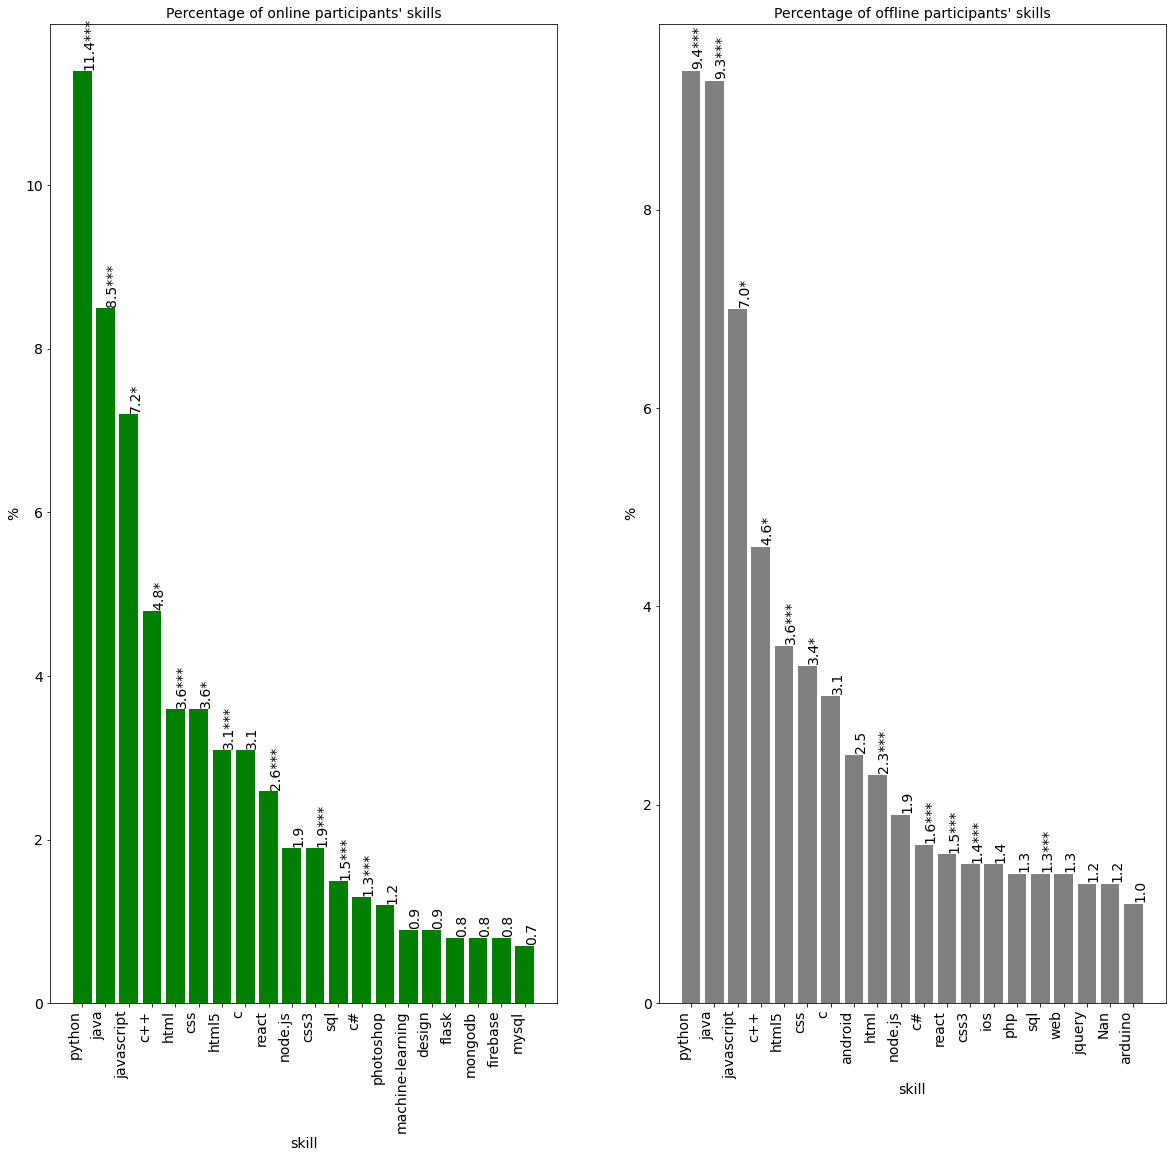

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 20))

axs[0].set_title("Percentage of online participants' skills", fontsize=14)
axs[0].set_ylabel("%", fontsize=14)
axs[0].set_xlabel("skill", fontsize=14)
axs[0].bar(grouped_skills_before['skills'], grouped_skills_before['pct'], color = 'green')

for i, row in grouped_skills_before.iterrows():
  significance = ''
  if row['skills'] in skills_pval:
    significance = f"{skills_pval[row['skills']][1]}"
  axs[0].annotate(str(row['pct'])+significance, xy=(row['skills'], row['pct']+ 0.05), rotation=90, fontsize=14)
axs[0].tick_params(axis='both', which='major', labelsize=14)

axs[1].set_title("Percentage of offline participants' skills", fontsize=14)
axs[1].set_ylabel("%", fontsize=14)
axs[1].set_xlabel("skill", fontsize=14)
axs[1].bar(grouped_skills_after['skills'], grouped_skills_after['pct'], color = 'grey')

for i, row in grouped_skills_after.iterrows():
  significance = ''
  if row['skills'] in skills_pval:
    significance = f"{skills_pval[row['skills']][1]}"
  axs[1].annotate(str(row['pct'])+significance, xy=(row['skills'], row['pct'] + 0.05), rotation=90, fontsize=14)
axs[1].tick_params(axis='both', which='major', labelsize=14)

fig.autofmt_xdate(rotation=90)

In [46]:
online_crit = {row['skills']:row['count'] for _, row in grouped_skills_before[['skills', 'count']].iterrows()}
offline_crit = {row['skills']:row['count'] for _, row in grouped_skills_after[['skills', 'count']].iterrows()}

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


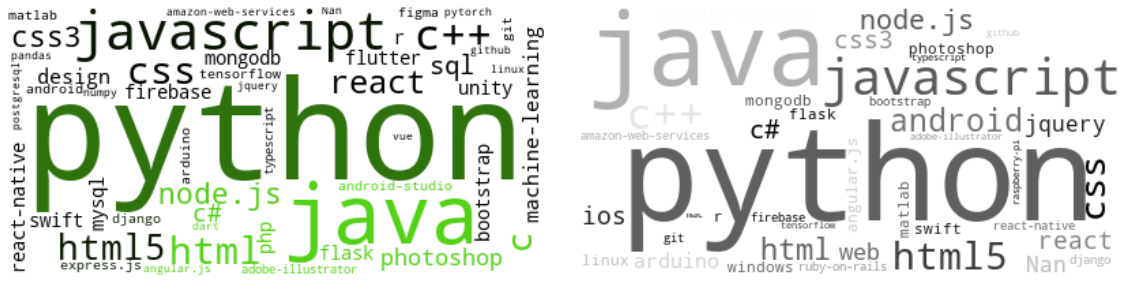

In [47]:
mask = np.array(Image.open(r'/content/drive/MyDrive/Thesis/cloud.png').convert("RGB"))
mask_2 = np.array(Image.open(r'/content/drive/MyDrive/Thesis/university-building.png').convert("RGB"))
image_colors = ImageColorGenerator(mask)
image_colors_2 = ImageColorGenerator(mask_2)
fig, axs = plt.subplots(1, 2, figsize=(20, 20))

wc1 = WordCloud(stopwords=stopwords,background_color='white', max_words=1000,collocations=False, colormap='rainbow').generate_from_frequencies(online_crit)

wc2 = WordCloud(stopwords=stopwords,background_color='white', max_words=1000,collocations=False, colormap='rainbow').generate_from_frequencies(offline_crit)


axs[0].imshow(wc1.recolor(color_func=image_colors), interpolation="bilinear")
axs[0].axis('off')
axs[1].imshow(wc2.recolor(color_func=image_colors_2), interpolation="bilinear")
axs[1].axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0.05)

## RQ2. Themes

In [97]:
test_2 = hacks[['themes', 'submission_gal_url', 'Location']]

N_top = 20

In [98]:
test_before = test_2[test_2['Location'] == 'Online']
themes_flatten_before = test_before['themes'].str.split(', ', expand=True).stack()
test_before = pd.DataFrame({'themes': themes_flatten_before, 'count': range(len(themes_flatten_before))})
test_before.reset_index(drop=True, inplace=True)
grouped_themes_before = test_before.groupby('themes').count().sort_values('count', ascending=False)
grouped_themes_before_sum = grouped_themes_before['count'].sum()
grouped_themes_before_pct = grouped_themes_before['count'] / grouped_themes_before_sum * 100
grouped_themes_before['pct'] = grouped_themes_before_pct.round(1)
grouped_themes_before = grouped_themes_before.reset_index()

In [99]:
test_after = test_2[test_2['Location'] == 'Offline']
themes_flatten_after = test_after['themes'].str.split(', ', expand=True).stack()
test_after = pd.DataFrame({'themes': themes_flatten_after, 'count': range(len(themes_flatten_after))})
test_after.reset_index(drop=True, inplace=True)
grouped_themes_after = test_after.groupby('themes').count().sort_values('count', ascending=False)
grouped_themes_after_sum = grouped_themes_after['count'].sum()
grouped_themes_after_pct = grouped_themes_after['count'] / grouped_themes_after_sum * 100
grouped_themes_after['pct'] = grouped_themes_after_pct.round(1)
grouped_themes_after = grouped_themes_after.reset_index()

In [105]:
all_skills = grouped_themes_before.merge(grouped_themes_after, on='themes')
d = all_skills.sort_values(by='pct_y', ascending=False)
#github, google cloud, heroku, discord usage increased in online hackathons
#on the other hand azure, twilio, amazon-web-services are at least somehow decreased when compare online vs offline
d.to_csv('all_skills')

In [103]:
online_crit = {row['themes']:row['count'] for _, row in grouped_themes_before[['themes', 'count']].iterrows()}
offline_crit = {row['themes']:row['count'] for _, row in grouped_themes_after[['themes', 'count']].iterrows()}

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


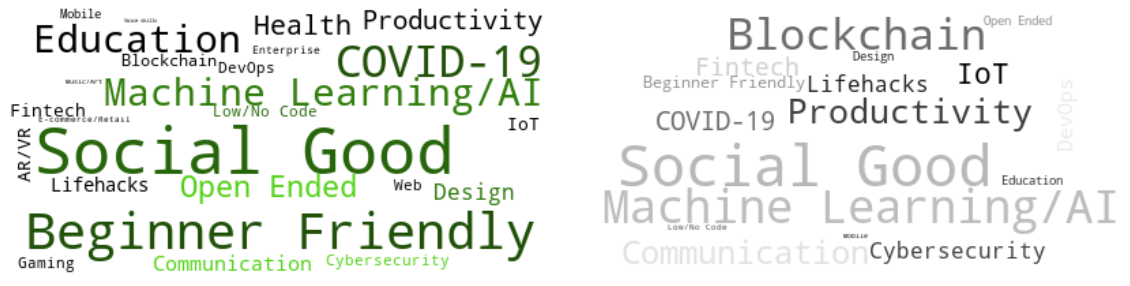

In [104]:
mask = np.array(Image.open(r'/content/drive/MyDrive/Thesis/cloud.png').convert("RGB"))
mask_2 = np.array(Image.open(r'/content/drive/MyDrive/Thesis/university-building.png').convert("RGB"))
image_colors = ImageColorGenerator(mask)
image_colors_2 = ImageColorGenerator(mask_2)
fig, axs = plt.subplots(1, 2, figsize=(20, 20))

wc1 = WordCloud(stopwords=stopwords,background_color='white', max_words=1000,collocations=False, colormap='rainbow').generate_from_frequencies(online_crit)

wc2 = WordCloud(stopwords=stopwords,background_color='white', max_words=1000,collocations=False, colormap='rainbow').generate_from_frequencies(offline_crit)


axs[0].imshow(wc1.recolor(color_func=image_colors), interpolation="bilinear")
axs[0].axis('off')
axs[1].imshow(wc2.recolor(color_func=image_colors_2), interpolation="bilinear")
axs[1].axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0.05)

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

before_themes = grouped_themes_before.loc[:N_top, 'themes'].tolist()
after_themes = grouped_themes_after.loc[:N_top, 'themes'].tolist()
themes = list(set(before_themes + after_themes))
themes_pval = {}

for t in themes:
  online_themes_count = grouped_themes_before.loc[grouped_themes_before['themes'] == t, 'count'].iloc[0]
  offline_themes_count = grouped_themes_after.loc[grouped_themes_after['themes'] == t, 'count'].iloc[0]
  _, pval = proportions_ztest([online_themes_count, offline_themes_count], [grouped_themes_before_sum, grouped_themes_after_sum])

  significance = ''
  if pval < 0.001:
    significance = '***'
  elif pval < 0.01:
    significance = '**'
  elif pval < 0.05:
    significance = '*'
  elif pval < 0.1:
    significance = '.'

  themes_pval[t] = (round(pval, 4), significance)

In [ ]:
grouped_themes_before = grouped_themes_before.iloc[:N_top, :]
grouped_themes_after = grouped_themes_after.iloc[:N_top, :]

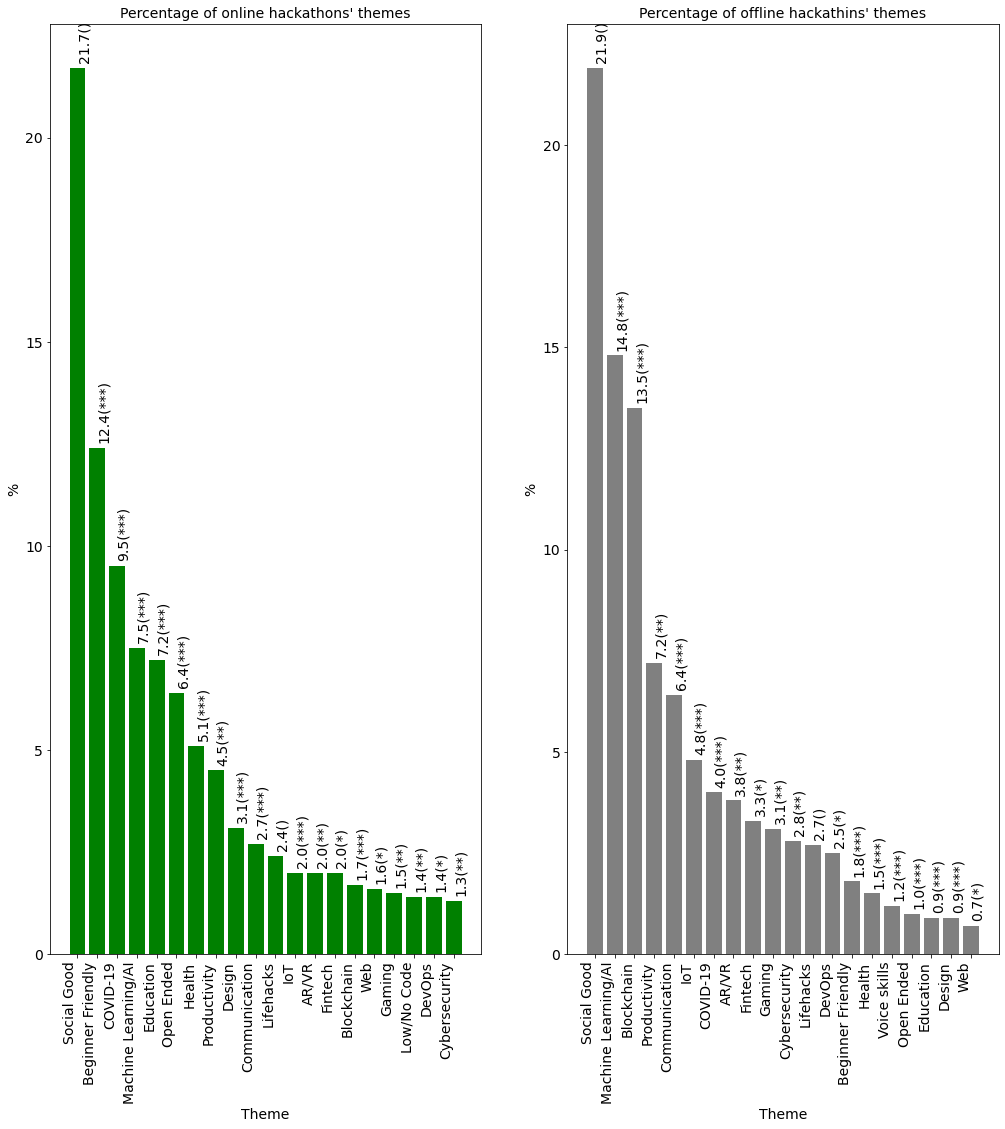

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(17, 19))

axs[0].set_title("Percentage of online hackathons' themes", fontsize=14)
axs[0].set_ylabel("%", fontsize=14)
axs[0].set_xlabel("Theme", fontsize=14)
axs[0].bar(grouped_themes_before['themes'], grouped_themes_before['pct'], color = 'green')

for i, row in grouped_themes_before.iterrows():
  axs[0].annotate(str(row['pct'])+f"({themes_pval[row['themes']][1]})", xy=(row['themes'], row['pct']+ 0.2), rotation=90, fontsize=14)
axs[0].tick_params(axis='both', which='major', labelsize=14)

axs[1].set_title("Percentage of offline hackathins' themes", fontsize=14)
axs[1].set_ylabel("%", fontsize=14)
axs[1].set_xlabel("Theme", fontsize=14)
axs[1].bar(grouped_themes_after['themes'], grouped_themes_after['pct'], color = 'grey')

for i, row in grouped_themes_after.iterrows():
  axs[1].annotate(str(row['pct'])+f"({themes_pval[row['themes']][1]})", xy=(row['themes'], row['pct'] + 0.2), rotation=90, fontsize=14)
axs[1].tick_params(axis='both', which='major', labelsize=14)

fig.autofmt_xdate(rotation=90)

## RQ3. Geography

In [107]:
data = projects
data = data[['start_date_format', 'Location', 'participants']]
data = (data.set_index(['start_date_format', 'Location'])
   .apply(lambda x: x.str.split(',').explode())
   .reset_index()) 
data = data.merge(participants, left_on = 'participants',right_on = '0', how='left')
data = data[['start_date_format','Location', 'country']]
data = data.merge(participants_locations, on = 'country', how='left')
data = data[['start_date_format','Location', 'country_eng']]
data = data[~ data['country_eng'].isna()]
data['start_date_format'] = pd.to_datetime(data['start_date_format'])
data['year'] = data['start_date_format'].dt.year

In [108]:
data = data[['year', 'Location', 'country_eng']]
grouped = data.groupby(['year', 'Location']).nunique().sort_values('year' , ascending=True).reset_index()
grouped_online = grouped[grouped['Location']=='Online']
grouped_offline = grouped[grouped['Location']=='Offline']

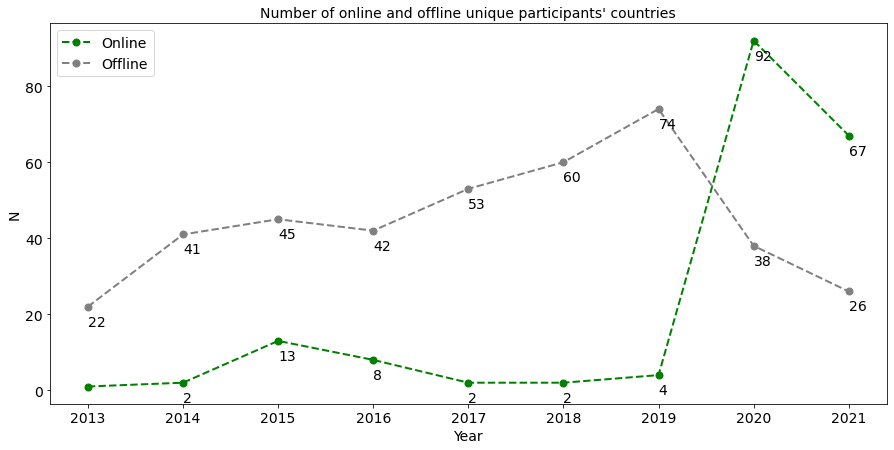

In [109]:
colors = ['green', 'grey']
fig, ax = plt.subplots(figsize=(15, 7))
for c, loc in [['green','Online'],['grey','Offline']]:
  ax.plot(grouped[grouped.Location==loc].year, grouped[grouped.Location==loc].country_eng, color = c, label= 'N',  marker='o', linestyle='dashed', 
          linewidth=2, markersize=7)
  ax.set_title("Number of online and offline unique participants' countries", fontsize=14)
  ax.set_xlabel('Year', fontsize=14)
  ax.set_ylabel('N', fontsize=14)
  ax.legend(['Online', 'Offline'], fontsize=14)
  ax.xaxis.set_ticks(grouped[grouped.Location==loc].year.values)

ax.tick_params(axis='both', which='major', labelsize=14)
for i, row in grouped_online.iterrows():
  ax.annotate(str(row['country_eng']), xy=(row['year'], row['country_eng'] - 5), fontsize=14)
for i, row in grouped_offline.iterrows():
  ax.annotate(str(row['country_eng']), xy=(row['year'], row['country_eng'] - 5), fontsize=14)

## Spatial distance and time zone distance

In [118]:
spatial_distance_diff = projects[['intergroup_spartial_dist', 'Location']]

grouped_spatial_distance = spatial_distance_diff.groupby('Location').agg({'intergroup_spartial_dist':['mean','std']}) #add error bar and standart deviation, min, max
grouped_spatial_distance.columns = ['mean', 'std']
grouped_spatial_distance['mean'] = grouped_spatial_distance['mean'].round(2)
grouped_spatial_distance['std'] = grouped_spatial_distance['std'].round(2)

grouped_spatial_distance = grouped_spatial_distance.reset_index()

In [120]:
mean_online_dists = np.mean(projects.loc[(projects['Location'] == 'Online'), 'intergroup_spartial_dist'])
mean_offline_dists = np.mean(projects.loc[(projects['Location'] == 'Offline'), 'intergroup_spartial_dist'])
SD_online_dists = np.std(projects.loc[(projects['Location'] ==  'Online'), 'intergroup_spartial_dist'])
SD_offline_dists = np.std(projects.loc[(projects['Location'] == 'Offline'), 'intergroup_spartial_dist'])

print(f"Mean and SD hack duration for online hacks: {mean_online_dists}, {SD_online_dists}")
print(f"Mean and SD hack duration for offline hacks: {mean_offline_dists}, {SD_offline_dists}")

online_dists = projects.loc[(projects['Location'] == 'Online'), 'intergroup_spartial_dist'].values
offline_dists = projects.loc[(projects['Location'] == 'Offline'), 'intergroup_spartial_dist'].values

stat_u, p2 = stats.mannwhitneyu(online_dists, offline_dists) #due to the fact that distribution is not normal we will use mann whitney u test

stat_u, p2 = stats.mannwhitneyu(online_dists, offline_dists)
if p2 < 0.001:
  significance = '***'
elif p2 < 0.01:
  significance = '**'
elif p2 < 0.05:
  significance = '*'
elif p2 < 0.1:
  significance = '.'
else:
  significance = ''
print(f"U-statistic: {stat_u}, p-value {p2}, {significance}")



Mean and SD hack duration for online hacks: 1381.0164729022804, 2409.431304756856
Mean and SD hack duration for offline hacks: 723.2125736838102, 1564.7860328849906
U-statistic: 181081660.0, p-value 4.746076152045083e-216, ***


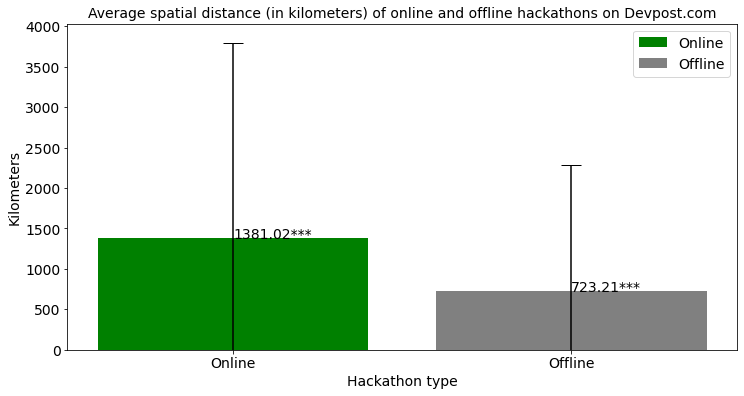

In [124]:
colors = ['green', 'grey']
fig, ax = plt.subplots(figsize=(12, 6))
for c, loc in [['green','Online'],['grey','Offline']]:
  ax.bar(grouped_spatial_distance[grouped_spatial_distance.Location==loc].Location, grouped_spatial_distance[grouped_spatial_distance.Location==loc]['mean'], yerr=grouped_spatial_distance[grouped_spatial_distance.Location==loc]['std'], capsize=10,color = c, label='mean spatial distance')
  ax.set_title('Average spatial distance (in kilometers) of online and offline hackathons on Devpost.com', fontsize=14)
  ax.set_xlabel('Hackathon type', fontsize=14)
  ax.set_ylabel('Kilometers', fontsize=14)
  ax.legend(['Online', 'Offline'], fontsize=14)
  ax.xaxis.set_ticks(grouped_spatial_distance.Location)
ax.tick_params(axis='both', which='major', labelsize=14)

for i, row in grouped_spatial_distance.iterrows():
  ax.annotate(str(row['mean'])+significance, xy=(row['Location'], row['mean'] + 0.15), fontsize=14)
plt.ylim(0,)
plt.show()

In [127]:
tz_distance_diff = projects[['intergroup_tz_dist', 'Location']]

grouped_tz_distance = tz_distance_diff.groupby('Location').agg({'intergroup_tz_dist':['mean','std']}) #add error bar and standart deviation, min, max
grouped_tz_distance.columns = ['mean', 'std']
grouped_tz_distance['mean'] = grouped_tz_distance['mean'].round(2)
grouped_tz_distance['std'] = grouped_tz_distance['std'].round(2)

grouped_tz_distance = grouped_tz_distance.reset_index()

In [128]:
mean_online_dists_tz = np.mean(projects.loc[(projects['Location'] == 'Online'), 'intergroup_tz_dist'])
mean_offline_dists_tz = np.mean(projects.loc[(projects['Location'] == 'Offline'), 'intergroup_tz_dist'])
SD_online_dists_tz = np.std(projects.loc[(projects['Location'] ==  'Online'), 'intergroup_tz_dist'])
SD_offline_dists_tz = np.std(projects.loc[(projects['Location'] == 'Offline'), 'intergroup_tz_dist'])

print(f"Mean and SD hack duration for online hacks: {mean_online_dists_tz}, {SD_online_dists_tz}")
print(f"Mean and SD hack duration for offline hacks: {mean_offline_dists_tz}, {SD_offline_dists_tz}")


online_tz_dists = projects.loc[(projects['Location'] == 'Online'), 'intergroup_tz_dist'].values
offline_tz_dists = projects.loc[(projects['Location'] == 'Offline'), 'intergroup_tz_dist'].values

stat_u, p2 = stats.mannwhitneyu(online_tz_dists, offline_tz_dists) #due to the fact that distribution is not normal we will use mann whitney u test

stat_u, p2 = stats.mannwhitneyu(online_tz_dists, offline_tz_dists)
if p2 < 0.001:
  significance = '***'
elif p2 < 0.01:
  significance = '**'
elif p2 < 0.05:
  significance = '*'
elif p2 < 0.1:
  significance = '.'
else:
  significance = ''
print(f"U-statistic: {stat_u}, p-value {p2}, {significance}")

Mean and SD hack duration for online hacks: 1.0397090221895884, 2.203746464666528
Mean and SD hack duration for offline hacks: 0.5427933030243716, 1.5224581813722102
U-statistic: 196826130.5, p-value 6.036856993759698e-140, ***


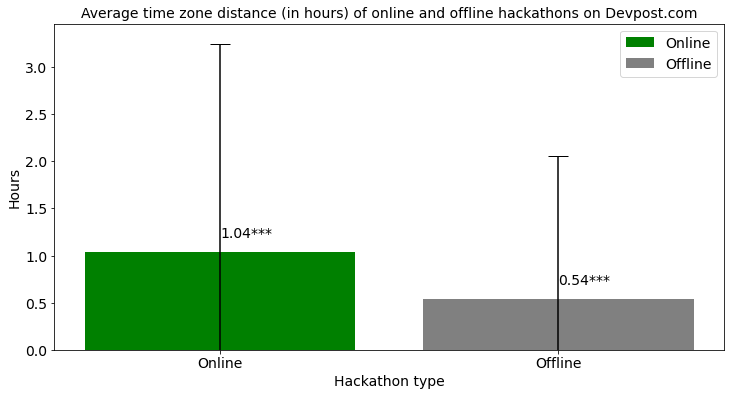

In [129]:
colors = ['green', 'grey']
fig, ax = plt.subplots(figsize=(12, 6))
for c, loc in [['green','Online'],['grey','Offline']]:
  ax.bar(grouped_tz_distance[grouped_tz_distance.Location==loc].Location, grouped_tz_distance[grouped_tz_distance.Location==loc]['mean'], yerr=grouped_tz_distance[grouped_tz_distance.Location==loc]['std'], capsize=10,color = c, label='mean time zone distance')
  ax.set_title('Average time zone distance (in hours) of online and offline hackathons on Devpost.com', fontsize=14)
  ax.set_xlabel('Hackathon type', fontsize=14)
  ax.set_ylabel('Hours', fontsize=14)
  ax.legend(['Online', 'Offline'], fontsize=14)
  ax.xaxis.set_ticks(grouped_tz_distance.Location)
ax.tick_params(axis='both', which='major', labelsize=14)

for i, row in grouped_tz_distance.iterrows():
  ax.annotate(str(row['mean'])+significance, xy=(row['Location'], row['mean'] + 0.15), fontsize=14)
plt.ylim(0,)
plt.show()

## Distance within the hackathon

In [131]:
spatial_distance_diff = hacks_dist[['intergroup_spartial_dist', 'Location']]

grouped_spatial_distance = spatial_distance_diff.groupby('Location').agg({'intergroup_spartial_dist':['mean','std']}) #add error bar and standart deviation, min, max
grouped_spatial_distance.columns = ['mean', 'std']
grouped_spatial_distance['mean'] = grouped_spatial_distance['mean'].round(2)
grouped_spatial_distance['std'] = grouped_spatial_distance['std'].round(2)

grouped_spatial_distance = grouped_spatial_distance.reset_index()

In [133]:
mean_online_dists = np.mean(hacks_dist.loc[(hacks_dist['Location'] == 'Online'), 'intergroup_spartial_dist'])
mean_offline_dists = np.mean(hacks_dist.loc[(hacks_dist['Location'] == 'Offline'), 'intergroup_spartial_dist'])
SD_online_dists = np.std(hacks_dist.loc[(hacks_dist['Location'] ==  'Online'), 'intergroup_spartial_dist'])
SD_offline_dists = np.std(hacks_dist.loc[(hacks_dist['Location'] == 'Offline'), 'intergroup_spartial_dist'])

print(f"Mean and SD hack duration for online hacks: {mean_online_dists}, {SD_online_dists}")
print(f"Mean and SD hack duration for offline hacks: {mean_offline_dists}, {SD_offline_dists}")

online_dists = hacks_dist.loc[(hacks_dist['Location'] == 'Online'), 'intergroup_spartial_dist'].values
offline_dists = hacks_dist.loc[(hacks_dist['Location'] == 'Offline'), 'intergroup_spartial_dist'].values

stat_u, p2 = stats.mannwhitneyu(online_dists, offline_dists) #due to the fact that distribution is not normal we will use mann whitney u test

stat_u, p2 = stats.mannwhitneyu(online_dists, offline_dists)
if p2 < 0.001:
  significance = '***'
elif p2 < 0.01:
  significance = '**'
elif p2 < 0.05:
  significance = '*'
elif p2 < 0.1:
  significance = '.'
else:
  significance = ''
print(f"U-statistic: {stat_u}, p-value {p2}, {significance}")

Mean and SD hack duration for online hacks: 3079.7348007638716, 2504.2442172175292
Mean and SD hack duration for offline hacks: 806.9288519249241, 1160.9738296202825
U-statistic: 664311.5, p-value 3.523695038100482e-157, ***


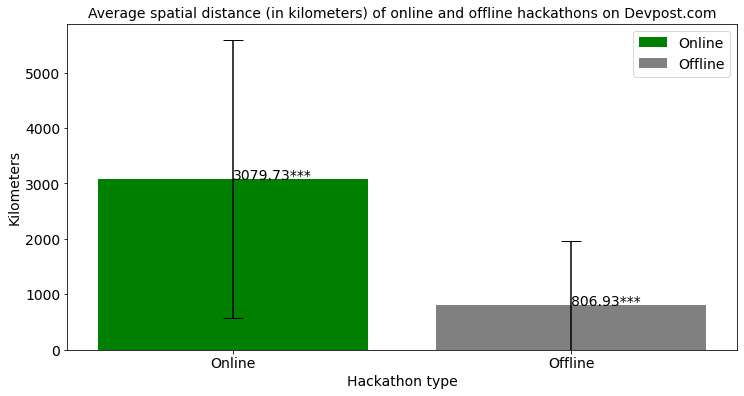

In [134]:
colors = ['green', 'grey']
fig, ax = plt.subplots(figsize=(12, 6))
for c, loc in [['green','Online'],['grey','Offline']]:
  ax.bar(grouped_spatial_distance[grouped_spatial_distance.Location==loc].Location, grouped_spatial_distance[grouped_spatial_distance.Location==loc]['mean'], yerr=grouped_spatial_distance[grouped_spatial_distance.Location==loc]['std'], capsize=10,color = c, label='mean spatial distance')
  ax.set_title('Average spatial distance (in kilometers) of online and offline hackathons on Devpost.com', fontsize=14)
  ax.set_xlabel('Hackathon type', fontsize=14)
  ax.set_ylabel('Kilometers', fontsize=14)
  ax.legend(['Online', 'Offline'], fontsize=14)
  ax.xaxis.set_ticks(grouped_spatial_distance.Location)
ax.tick_params(axis='both', which='major', labelsize=14)

for i, row in grouped_spatial_distance.iterrows():
  ax.annotate(str(row['mean'])+significance, xy=(row['Location'], row['mean'] + 0.15), fontsize=14)
plt.ylim(0,)
plt.show()

In [135]:
tz_distance_diff = hacks_dist[['intergroup_tz_dist', 'Location']]

grouped_tz_distance = tz_distance_diff.groupby('Location').agg({'intergroup_tz_dist':['mean','std']}) #add error bar and standart deviation, min, max
grouped_tz_distance.columns = ['mean', 'std']
grouped_tz_distance['mean'] = grouped_tz_distance['mean'].round(2)
grouped_tz_distance['std'] = grouped_tz_distance['std'].round(2)

grouped_tz_distance = grouped_tz_distance.reset_index()

In [136]:
mean_online_dists_tz = np.mean(hacks_dist.loc[(hacks_dist['Location'] == 'Online'), 'intergroup_tz_dist'])
mean_offline_dists_tz = np.mean(hacks_dist.loc[(hacks_dist['Location'] == 'Offline'), 'intergroup_tz_dist'])
SD_online_dists_tz = np.std(hacks_dist.loc[(hacks_dist['Location'] ==  'Online'), 'intergroup_tz_dist'])
SD_offline_dists_tz = np.std(hacks_dist.loc[(hacks_dist['Location'] == 'Offline'), 'intergroup_tz_dist'])

print(f"Mean and SD hack duration for online hacks: {mean_online_dists_tz}, {SD_online_dists_tz}")
print(f"Mean and SD hack duration for offline hacks: {mean_offline_dists_tz}, {SD_offline_dists_tz}")

online_dists = hacks_dist.loc[(hacks_dist['Location'] == 'Online'), 'intergroup_tz_dist'].values
offline_dists = hacks_dist.loc[(hacks_dist['Location'] == 'Offline'), 'intergroup_tz_dist'].values

stat_u, p2 = stats.mannwhitneyu(online_dists, offline_dists) #due to the fact that distribution is not normal we will use mann whitney u test

stat_u, p2 = stats.mannwhitneyu(online_dists, offline_dists)
if p2 < 0.001:
  significance = '***'
elif p2 < 0.01:
  significance = '**'
elif p2 < 0.05:
  significance = '*'
elif p2 < 0.1:
  significance = '.'
else:
  significance = ''
print(f"U-statistic: {stat_u}, p-value {p2}, {significance}")

Mean and SD hack duration for online hacks: 2.43431089740151, 2.2563064488945948
Mean and SD hack duration for offline hacks: 0.5059015403118913, 1.1034309636589383
U-statistic: 725486.0, p-value 5.951171306104971e-138, ***


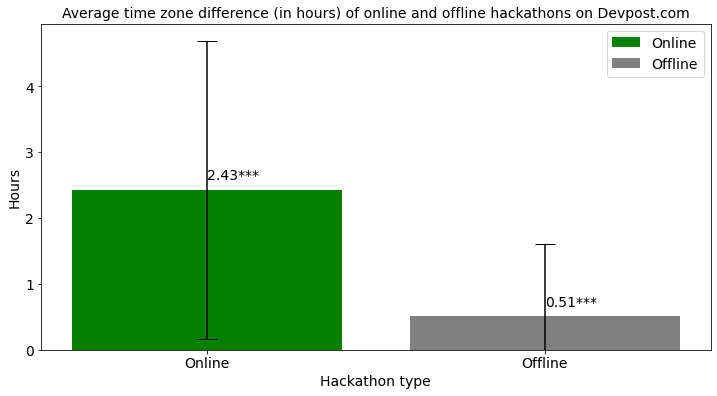

In [139]:
colors = ['green', 'grey']
fig, ax = plt.subplots(figsize=(12, 6))
for c, loc in [['green','Online'],['grey','Offline']]:
  ax.bar(grouped_tz_distance[grouped_tz_distance.Location==loc].Location, grouped_tz_distance[grouped_tz_distance.Location==loc]['mean'], yerr=grouped_tz_distance[grouped_tz_distance.Location==loc]['std'], capsize=10,color = c, label='mean spatial distance')
  ax.set_title('Average time zone difference (in hours) of online and offline hackathons on Devpost.com', fontsize=14)
  ax.set_xlabel('Hackathon type', fontsize=14)
  ax.set_ylabel('Hours', fontsize=14)
  ax.legend(['Online', 'Offline'], fontsize=14)
  ax.xaxis.set_ticks(grouped_tz_distance.Location)
ax.tick_params(axis='both', which='major', labelsize=14)

for i, row in grouped_tz_distance.iterrows():
  ax.annotate(str(row['mean'])+significance, xy=(row['Location'], row['mean'] + 0.15), fontsize=14)
plt.ylim(0,)
plt.show()

## Countries trend offline and online

In [ ]:
data_2 = data[['year', 'country_eng']]
data_2['country'] = data_2['country_eng']
grouped_2 = data_2.groupby(['year', 'country']).count().sort_values(['year', 'country_eng'] , ascending=[True, False]).reset_index()
years = grouped_2['year'].unique()

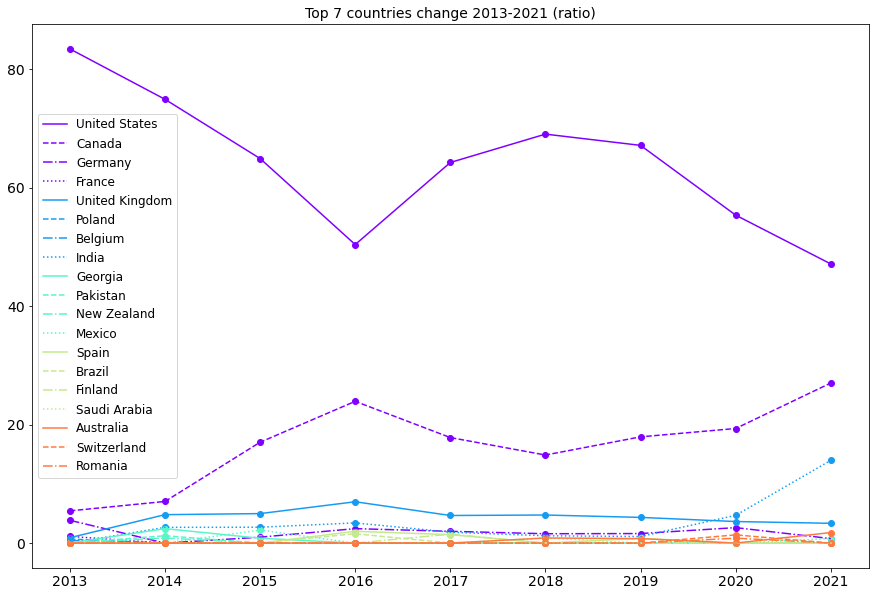

In [ ]:
# remove numpy warning 
import warnings

warnings.filterwarnings('ignore')


result_df = pd.DataFrame(columns=grouped_2.columns)
for i, year in enumerate(years):
  year_df = grouped_2.loc[grouped_2['year'] == year, :].copy()
  year_df['country_eng'] = (year_df['country_eng'] / year_df['country_eng'].sum() * 100).round(2)
  
  if year_df.shape[0] > 7:
      year_df = year_df.iloc[:7, :]

  result_df = pd.concat([result_df, year_df])

countries = result_df.country.unique()
NUM_COLORS = len(countries)
LINE_STYLES = ['solid', 'dashed', 'dashdot', 'dotted']
NUM_STYLES = len(LINE_STYLES)

cm = plt.get_cmap('rainbow')

plt.figure(figsize=(15,10))
for i, c in enumerate(countries):
  country_df = result_df.loc[result_df['country'] == c, :].copy()
  country_year_ratios = [country_df.loc[country_df['year'] == y, 'country_eng'] if not country_df.loc[country_df['year'] == y, 'country_eng'].empty else 0 for y in years]
  plt.plot(years, country_year_ratios, label=c, color=cm(i//NUM_STYLES*float(NUM_STYLES)/NUM_COLORS), linestyle=LINE_STYLES[i%NUM_STYLES])
  plt.scatter(years, country_year_ratios, color=cm(i//NUM_STYLES*float(NUM_STYLES)/NUM_COLORS))

plt.title('Top 7 countries change 2013-2021 (ratio)', fontsize=14)
plt.legend(fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

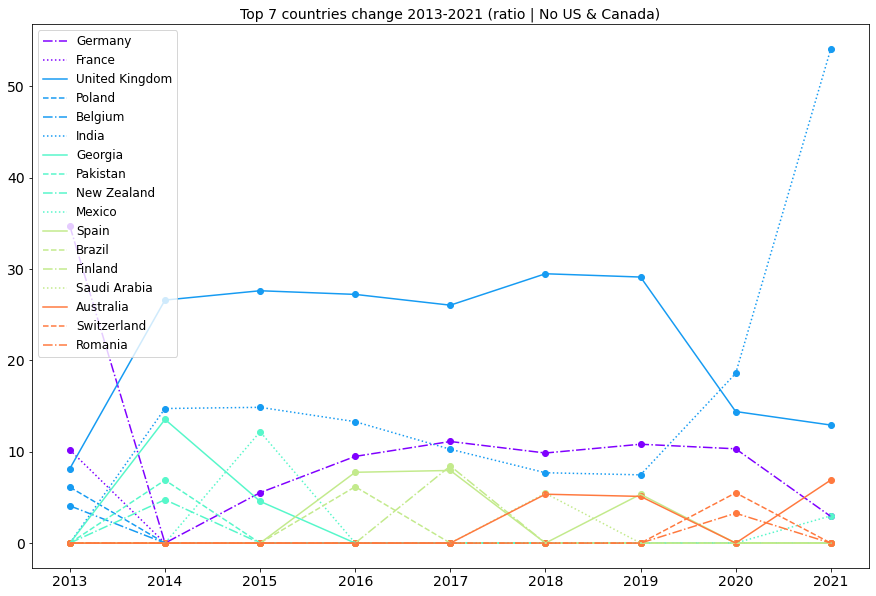

In [ ]:
exclude_countries = ['United States', 'Canada']

result_df = pd.DataFrame(columns=grouped_2.columns)
grouped_2_mod = grouped_2.copy()
grouped_2_mod.loc[grouped_2_mod.country.isin(exclude_countries), 'country_eng'] = 0
for i, year in enumerate(years):
  year_df = grouped_2_mod.loc[grouped_2_mod['year'] == year, :].copy()
  year_df['country_eng'] = (year_df['country_eng'] / year_df['country_eng'].sum() * 100).round(2)
  
  if year_df.shape[0] > 7:
      year_df = year_df.iloc[:7, :]

  result_df = pd.concat([result_df, year_df])

countries = [c for c in result_df.country.unique() if c not in exclude_countries]

plt.figure(figsize=(15,10))
for i, c in enumerate(countries):
  country_df = result_df.loc[result_df['country'] == c, :].copy()
  country_year_ratios = [country_df.loc[country_df['year'] == y, 'country_eng'] if not country_df.loc[country_df['year'] == y, 'country_eng'].empty else 0 for y in years]
  plt.plot(years, country_year_ratios, label=c, color=cm((i + 2 )//NUM_STYLES*float(NUM_STYLES)/NUM_COLORS), linestyle=LINE_STYLES[(i + 2)%NUM_STYLES])
  plt.scatter(years, country_year_ratios, color=cm((i + 2)//NUM_STYLES*float(NUM_STYLES)/NUM_COLORS))

plt.title('Top 7 countries change 2013-2021 (ratio | No US & Canada)', fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

## Now let's check the same for offline and online hackathons

## Online

In [ ]:
data_2 = data.loc[data['Location'] == 'Online',['year', 'country_eng']]

data_2['country'] = data_2['country_eng']
grouped_2 = data_2.groupby(['year', 'country']).count().sort_values(['year', 'country_eng'] , ascending=[True, False]).reset_index()
years = grouped_2['year'].unique()

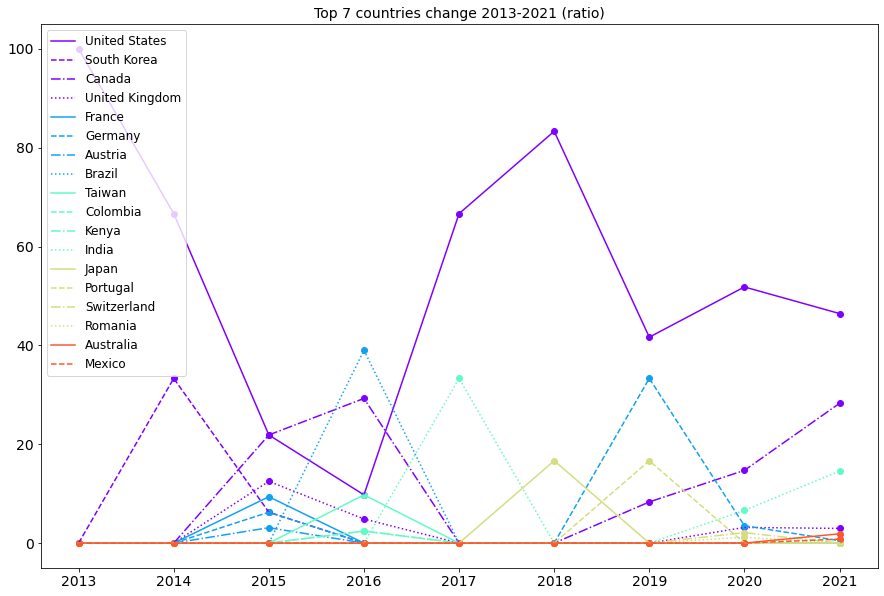

In [ ]:
import warnings

warnings.filterwarnings('ignore')


result_df = pd.DataFrame(columns=grouped_2.columns)
for i, year in enumerate(years):
  year_df = grouped_2.loc[grouped_2['year'] == year, :].copy()
  year_df['country_eng'] = (year_df['country_eng'] / year_df['country_eng'].sum() * 100).round(2)
  
  if year_df.shape[0] > 7:
      year_df = year_df.iloc[:7, :]

  result_df = pd.concat([result_df, year_df])

countries = result_df.country.unique()
NUM_COLORS = len(countries)
LINE_STYLES = ['solid', 'dashed', 'dashdot', 'dotted']
NUM_STYLES = len(LINE_STYLES)

cm = plt.get_cmap('rainbow')

plt.figure(figsize=(15,10))
for i, c in enumerate(countries):
  country_df = result_df.loc[result_df['country'] == c, :].copy()
  country_year_ratios = [country_df.loc[country_df['year'] == y, 'country_eng'] if not country_df.loc[country_df['year'] == y, 'country_eng'].empty else 0 for y in years]
  plt.plot(years, country_year_ratios, label=c, color=cm(i//NUM_STYLES*float(NUM_STYLES)/NUM_COLORS), linestyle=LINE_STYLES[i%NUM_STYLES])
  plt.scatter(years, country_year_ratios, color=cm(i//NUM_STYLES*float(NUM_STYLES)/NUM_COLORS))

plt.title('Top 7 countries change 2013-2021 (ratio)', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

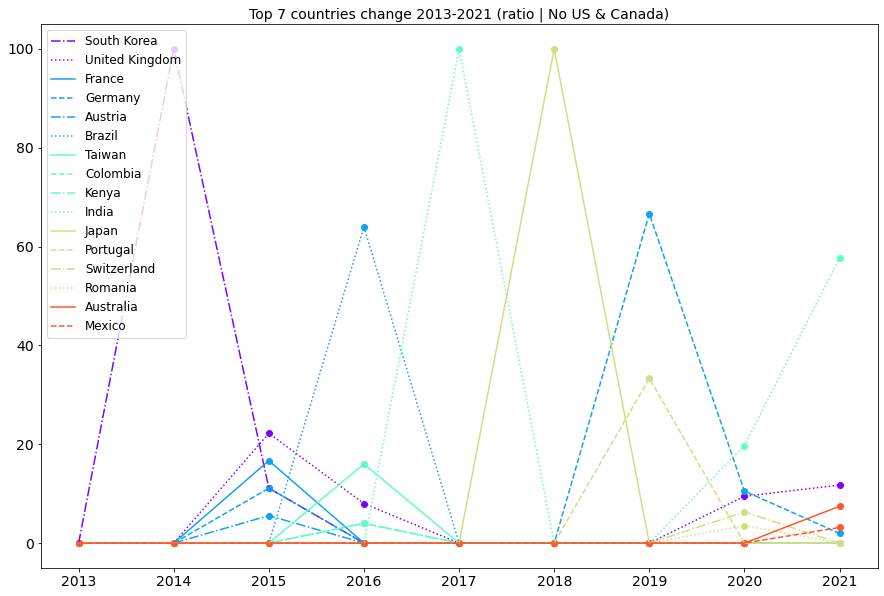

In [ ]:
exclude_countries = ['United States', 'Canada']

result_df = pd.DataFrame(columns=grouped_2.columns)
grouped_2_mod = grouped_2.copy()
grouped_2_mod.loc[grouped_2_mod.country.isin(exclude_countries), 'country_eng'] = 0
for i, year in enumerate(years):
  year_df = grouped_2_mod.loc[grouped_2_mod['year'] == year, :].copy()
  year_df['country_eng'] = (year_df['country_eng'] / year_df['country_eng'].sum() * 100).round(2)
  
  if year_df.shape[0] > 7:
      year_df = year_df.iloc[:7, :]

  result_df = pd.concat([result_df, year_df])

countries = [c for c in result_df.country.unique() if c not in exclude_countries]

plt.figure(figsize=(15,10))
for i, c in enumerate(countries):
  country_df = result_df.loc[result_df['country'] == c, :].copy()
  country_year_ratios = [country_df.loc[country_df['year'] == y, 'country_eng'] if not country_df.loc[country_df['year'] == y, 'country_eng'].empty else 0 for y in years]
  plt.plot(years, country_year_ratios, label=c, color=cm((i + 2 )//NUM_STYLES*float(NUM_STYLES)/NUM_COLORS), linestyle=LINE_STYLES[(i + 2)%NUM_STYLES])
  plt.scatter(years, country_year_ratios, color=cm((i + 2)//NUM_STYLES*float(NUM_STYLES)/NUM_COLORS))

plt.title('Top 7 countries change 2013-2021 (ratio | No US & Canada)', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

# Offline

In [ ]:
data_2 = data.loc[data['Location'] == 'Offline',['year', 'country_eng']]

data_2['country'] = data_2['country_eng']
grouped_2 = data_2.groupby(['year', 'country']).count().sort_values(['year', 'country_eng'] , ascending=[True, False]).reset_index()
years = grouped_2['year'].unique()

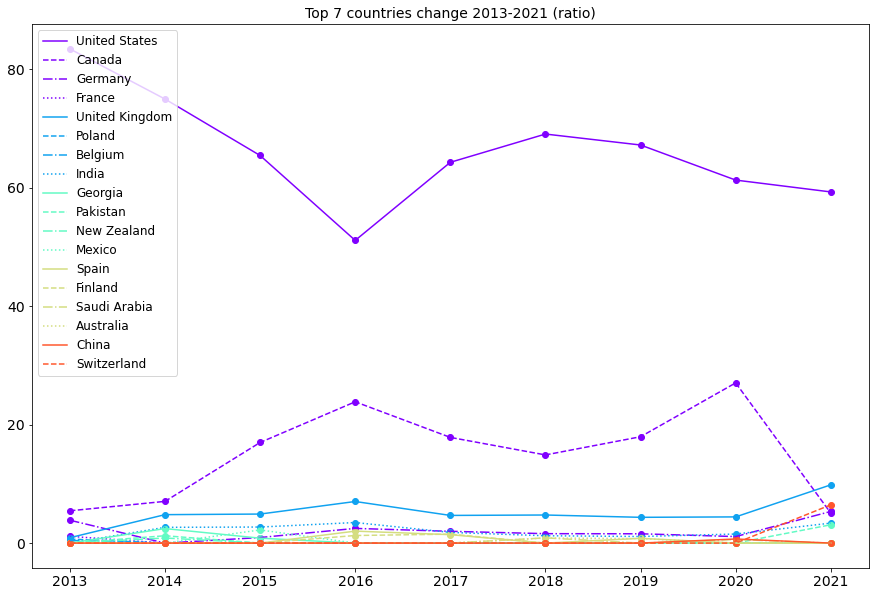

In [ ]:
import warnings

warnings.filterwarnings('ignore')


result_df = pd.DataFrame(columns=grouped_2.columns)
for i, year in enumerate(years):
  year_df = grouped_2.loc[grouped_2['year'] == year, :].copy()
  year_df['country_eng'] = (year_df['country_eng'] / year_df['country_eng'].sum() * 100).round(2)
  
  if year_df.shape[0] > 7:
      year_df = year_df.iloc[:7, :]

  result_df = pd.concat([result_df, year_df])

countries = result_df.country.unique()
NUM_COLORS = len(countries)
LINE_STYLES = ['solid', 'dashed', 'dashdot', 'dotted']
NUM_STYLES = len(LINE_STYLES)

cm = plt.get_cmap('rainbow')

plt.figure(figsize=(15,10))
for i, c in enumerate(countries):
  country_df = result_df.loc[result_df['country'] == c, :].copy()
  country_year_ratios = [country_df.loc[country_df['year'] == y, 'country_eng'] if not country_df.loc[country_df['year'] == y, 'country_eng'].empty else 0 for y in years]
  plt.plot(years, country_year_ratios, label=c, color=cm(i//NUM_STYLES*float(NUM_STYLES)/NUM_COLORS), linestyle=LINE_STYLES[i%NUM_STYLES])
  plt.scatter(years, country_year_ratios, color=cm(i//NUM_STYLES*float(NUM_STYLES)/NUM_COLORS))

plt.title('Top 7 countries change 2013-2021 (ratio)', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

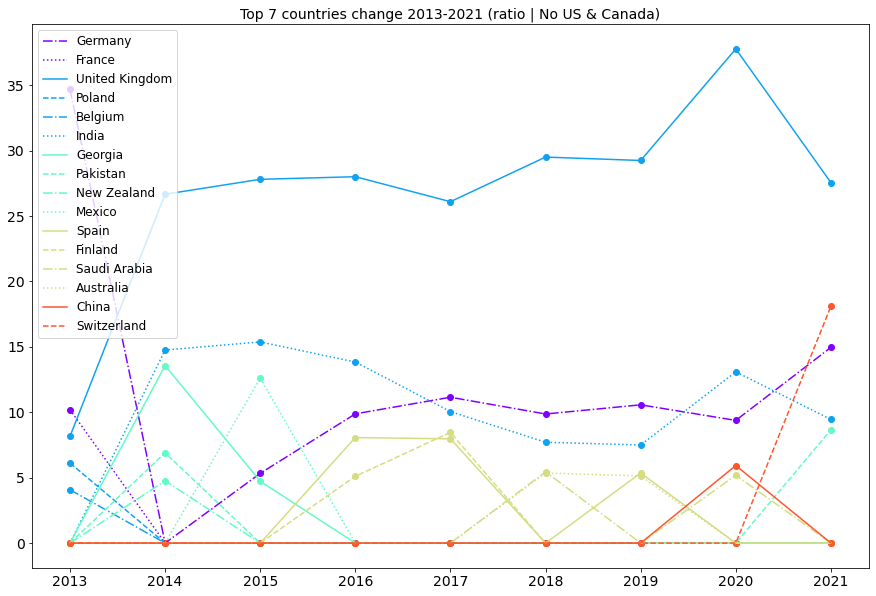

In [ ]:
exclude_countries = ['United States', 'Canada']

result_df = pd.DataFrame(columns=grouped_2.columns)
grouped_2_mod = grouped_2.copy()
grouped_2_mod.loc[grouped_2_mod.country.isin(exclude_countries), 'country_eng'] = 0
for i, year in enumerate(years):
  year_df = grouped_2_mod.loc[grouped_2_mod['year'] == year, :].copy()
  year_df['country_eng'] = (year_df['country_eng'] / year_df['country_eng'].sum() * 100).round(2)
  
  if year_df.shape[0] > 7:
      year_df = year_df.iloc[:7, :]

  result_df = pd.concat([result_df, year_df])

countries = [c for c in result_df.country.unique() if c not in exclude_countries]

plt.figure(figsize=(15,10))
for i, c in enumerate(countries):
  country_df = result_df.loc[result_df['country'] == c, :].copy()
  country_year_ratios = [country_df.loc[country_df['year'] == y, 'country_eng'] if not country_df.loc[country_df['year'] == y, 'country_eng'].empty else 0 for y in years]
  plt.plot(years, country_year_ratios, label=c, color=cm((i + 2 )//NUM_STYLES*float(NUM_STYLES)/NUM_COLORS), linestyle=LINE_STYLES[(i + 2)%NUM_STYLES])
  plt.scatter(years, country_year_ratios, color=cm((i + 2)//NUM_STYLES*float(NUM_STYLES)/NUM_COLORS))

plt.title('Top 7 countries change 2013-2021 (ratio | No US & Canada)', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()